In [ ]:
import numpy as np
import cv2
import networkx as nx

def skeleton_to_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape

    # Directions for 8-neighbor
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),          (0, 1),
                  (1, -1),  (1, 0), (1, 1)]

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                G.add_node((x, y))
                for dx, dy in directions:
                    nx_, ny_ = x + dx, y + dy
                    if 0 <= nx_ < rows and 0 <= ny_ < cols and skeleton[nx_, ny_] == 1:
                        # Distance: 1 for direct neighbors, sqrt(2) for diagonals
                        if abs(dx) + abs(dy) == 2:
                            weight = np.sqrt(2)
                        else:
                            weight = 1
                        G.add_edge((x, y), (nx_, ny_), weight=weight)
    return G

def find_longest_path(G):
    # Start from an arbitrary node
    start_node = list(G.nodes())[0]

    # First Dijkstra to find farthest node from start_node
    lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='weight')
    farthest_node = max(lengths, key=lengths.get)

    # Second Dijkstra from farthest_node
    lengths = nx.single_source_dijkstra_path_length(G, farthest_node, weight='weight')
    other_farthest_node = max(lengths, key=lengths.get)

    # Get the longest path
    path = nx.shortest_path(G, source=farthest_node, target=other_farthest_node, weight='weight')

    # Calculate the total crack length (sum of edge weights)
    crack_length = 0
    for i in range(len(path)-1):
        crack_length += G[path[i]][path[i+1]]['weight']

    return crack_length, path

# Example Usage
# Load your skeletonized image
skeleton_img = cv2.imread('/content/drive/MyDrive/Crack Segmentaion/mask.png', 0)
_, skeleton_binary = cv2.threshold(skeleton_img, 127, 1, cv2.THRESH_BINARY)

# Build graph
G = skeleton_to_graph(skeleton_binary)

# Find crack length
crack_length, longest_path = find_longest_path(G)

print(f"Estimated Crack Length: {crack_length} pixels")


Estimated Crack Length: 673.7594513539353 pixels


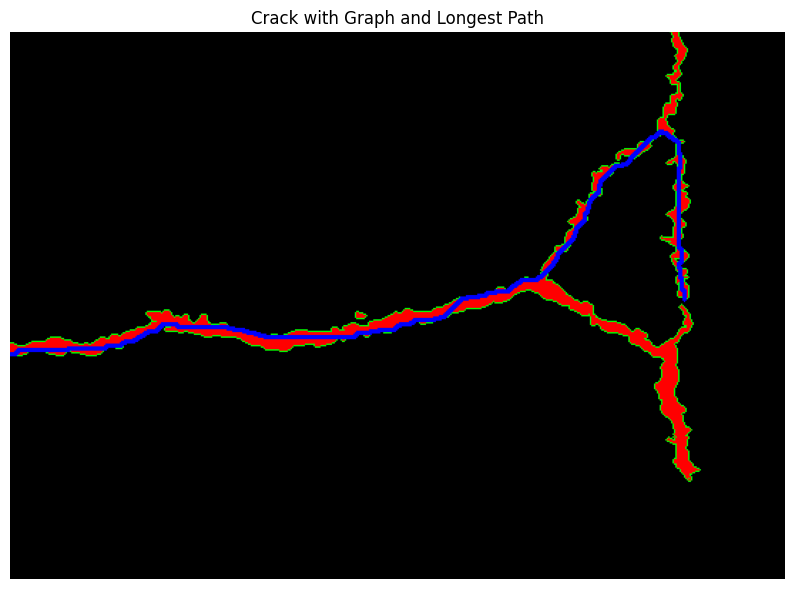

Estimated Crack Length: 673.76 pixels
Estimated Average Crack Width: 22.44 pixels


In [ ]:
import numpy as np
import cv2
import networkx as nx
import matplotlib.pyplot as plt

def skeleton_to_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape

    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),          (0, 1),
                  (1, -1),  (1, 0), (1, 1)]

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                G.add_node((x, y))
                for dx, dy in directions:
                    nx_, ny_ = x + dx, y + dy
                    if 0 <= nx_ < rows and 0 <= ny_ < cols and skeleton[nx_, ny_] == 1:
                        if abs(dx) + abs(dy) == 2:
                            weight = np.sqrt(2)
                        else:
                            weight = 1
                        G.add_edge((x, y), (nx_, ny_), weight=weight)
    return G

def find_longest_path(G):
    start_node = list(G.nodes())[0]
    lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='weight')
    farthest_node = max(lengths, key=lengths.get)

    lengths = nx.single_source_dijkstra_path_length(G, farthest_node, weight='weight')
    other_farthest_node = max(lengths, key=lengths.get)

    path = nx.shortest_path(G, source=farthest_node, target=other_farthest_node, weight='weight')

    crack_length = 0
    for i in range(len(path)-1):
        crack_length += G[path[i]][path[i+1]]['weight']

    return crack_length, path

def estimate_crack_width(skeleton):
    widths = []
    rows, cols = skeleton.shape

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                # Move horizontally to left and right (easy approx)
                left, right = 0, 0
                while y - left - 1 >= 0 and skeleton[x, y - left - 1] == 1:
                    left += 1
                while y + right + 1 < cols and skeleton[x, y + right + 1] == 1:
                    right += 1
                local_width = left + right + 1  # include center pixel
                widths.append(local_width)

    if widths:
        avg_width = np.mean(widths)
    else:
        avg_width = 0
    return avg_width

def visualize_crack_and_graph(original_img, skeleton, G, longest_path):
    vis_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)

    # Draw all nodes
    for (x, y) in G.nodes():
        cv2.circle(vis_img, (y, x), 1, (0, 255, 0), -1)

    # Draw all edges
    for (u, v) in G.edges():
        cv2.line(vis_img, (u[1], u[0]), (v[1], v[0]), (255, 0, 0), 1)

    # Highlight the longest path
    for i in range(len(longest_path) - 1):
        u, v = longest_path[i], longest_path[i+1]
        cv2.line(vis_img, (u[1], u[0]), (v[1], v[0]), (0, 0, 255), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img)
    plt.axis('off')
    plt.title("Crack with Graph and Longest Path")
    plt.show()

# ---------------------- Example Usage ----------------------

# Load the skeletonized image
skeleton_img = cv2.imread('/content/drive/MyDrive/Crack Segmentaion/mask.png', 0)
_, skeleton_binary = cv2.threshold(skeleton_img, 127, 1, cv2.THRESH_BINARY)

# Build the graph
G = skeleton_to_graph(skeleton_binary)

# Find the longest crack path
crack_length, longest_path = find_longest_path(G)

# Estimate crack width
crack_width = estimate_crack_width(skeleton_binary)

# Visualize everything
visualize_crack_and_graph(skeleton_img, skeleton_binary, G, longest_path)

print(f"Estimated Crack Length: {crack_length:.2f} pixels")
print(f"Estimated Average Crack Width: {crack_width:.2f} pixels")


Processing image: 11165-2_meta_ensemble_prediction.png


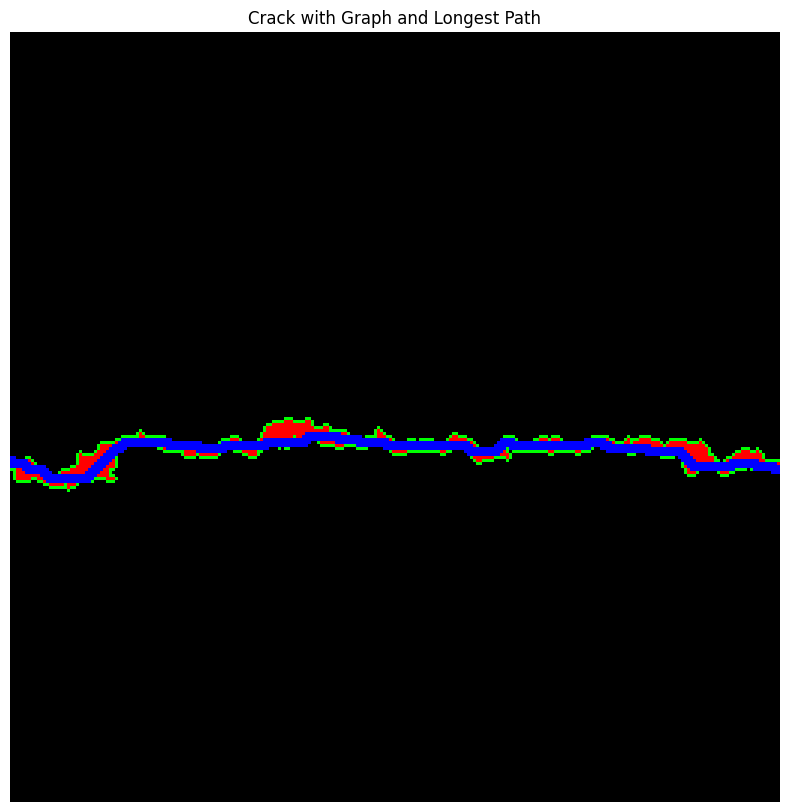

Estimated Crack Length: 273.64 pixels
Estimated Average Crack Width: 14.42 pixels
--------------------------------------------------
Processing image: 11188_meta_ensemble_prediction.png


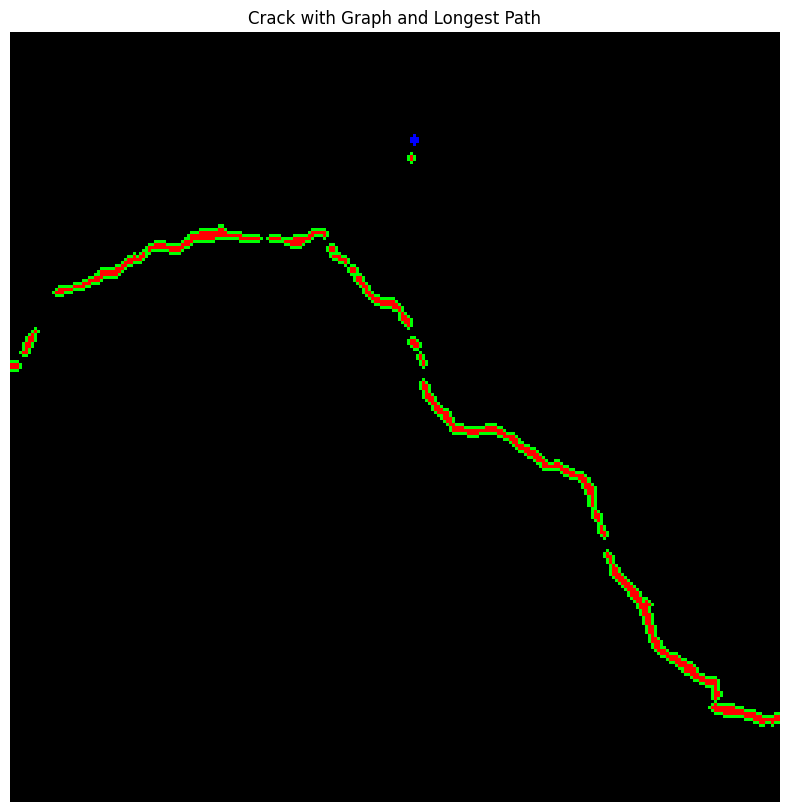

Estimated Crack Length: 1.00 pixels
Estimated Average Crack Width: 4.93 pixels
--------------------------------------------------
Processing image: 11122-1_meta_ensemble_prediction.png


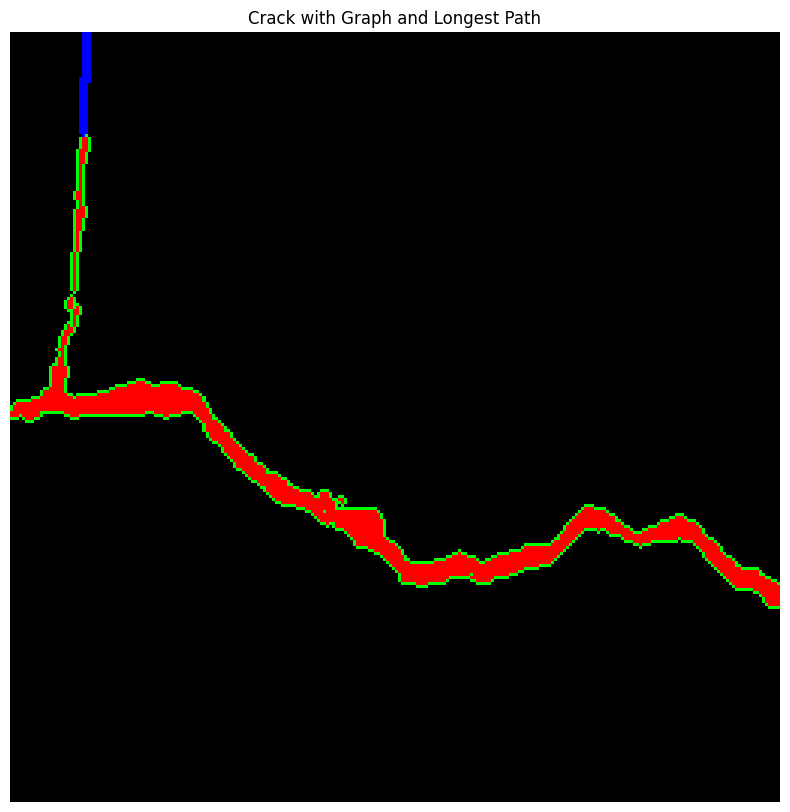

Estimated Crack Length: 33.41 pixels
Estimated Average Crack Width: 21.35 pixels
--------------------------------------------------
Processing image: IMG36-1_meta_ensemble_prediction.png


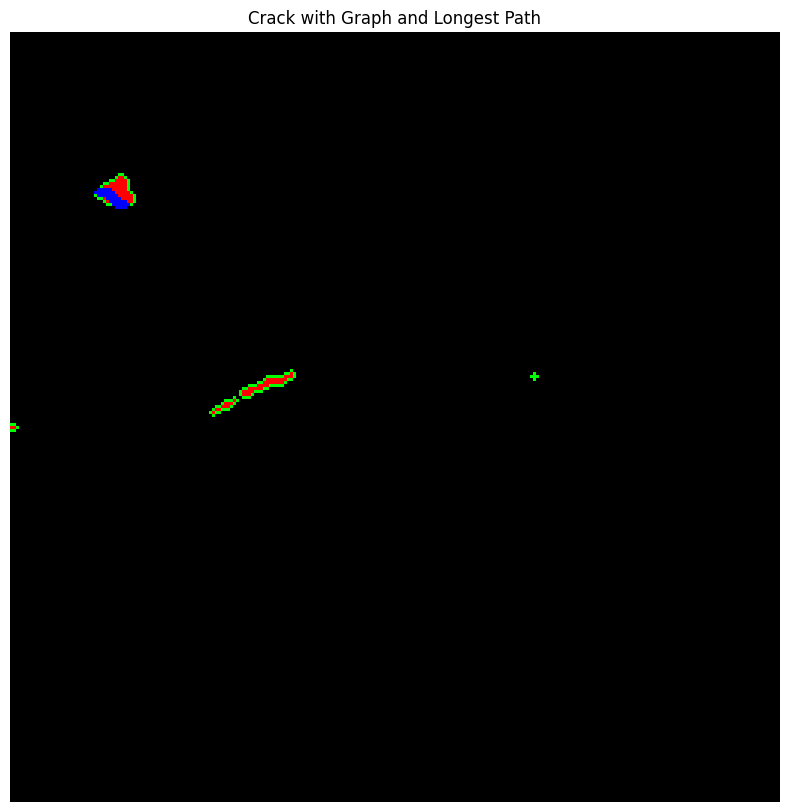

Estimated Crack Length: 10.66 pixels
Estimated Average Crack Width: 7.10 pixels
--------------------------------------------------
Processing image: IMG_5776-2_meta_ensemble_prediction.png


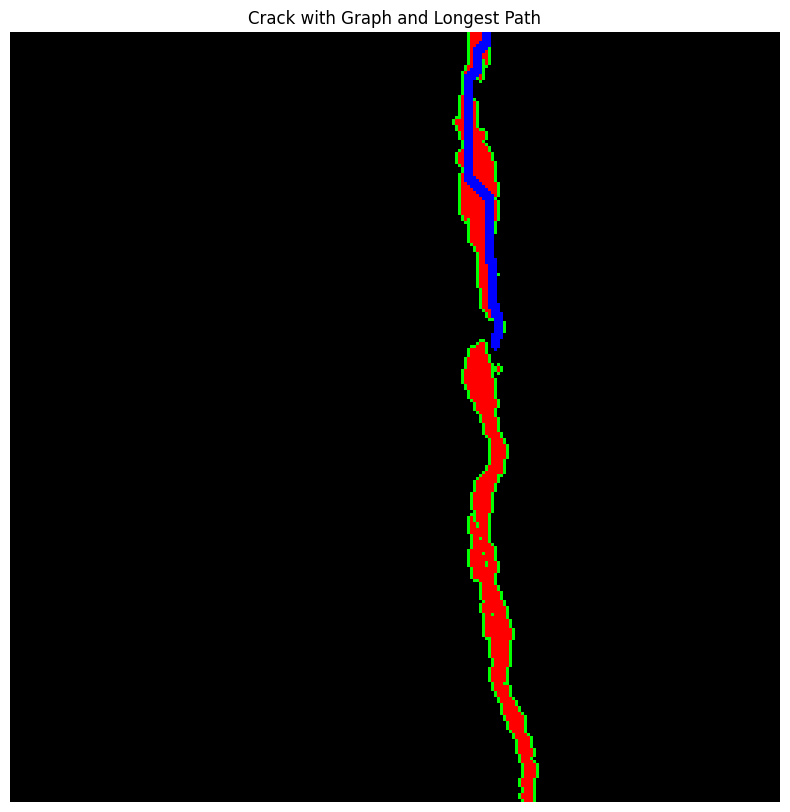

Estimated Crack Length: 111.04 pixels
Estimated Average Crack Width: 6.78 pixels
--------------------------------------------------
Processing image: 11155-1_meta_ensemble_prediction.png


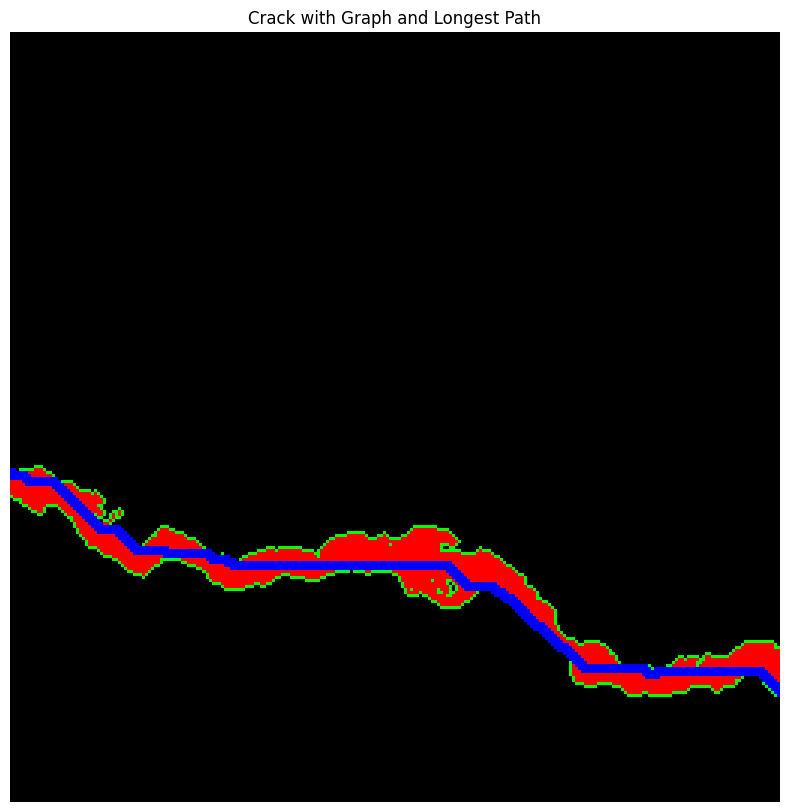

Estimated Crack Length: 286.65 pixels
Estimated Average Crack Width: 31.83 pixels
--------------------------------------------------
Processing image: IMG14-1_meta_ensemble_prediction.png


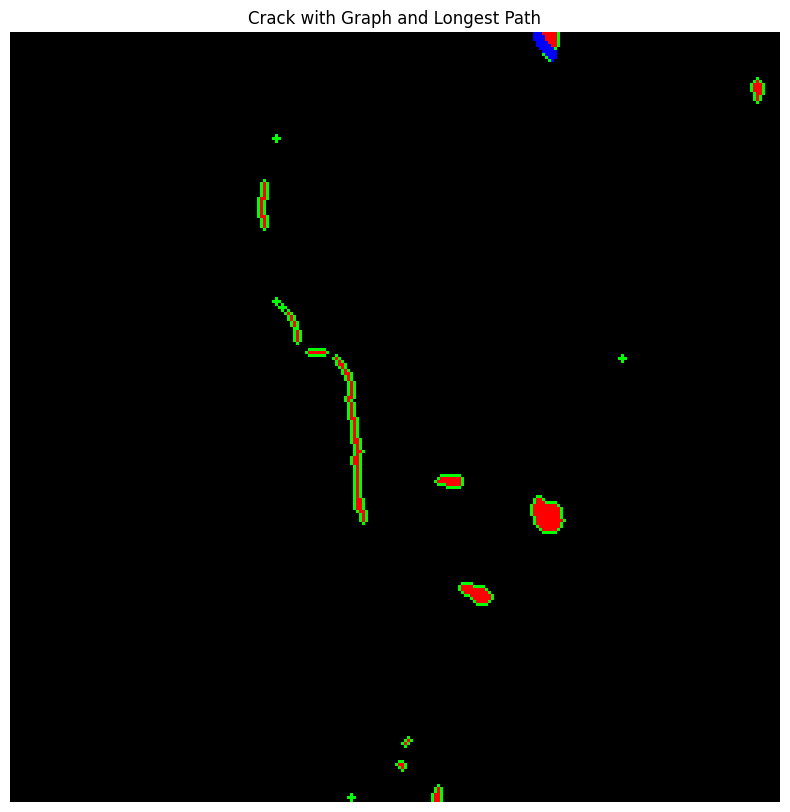

Estimated Crack Length: 10.07 pixels
Estimated Average Crack Width: 4.64 pixels
--------------------------------------------------
Processing image: IMG13-2_meta_ensemble_prediction.png


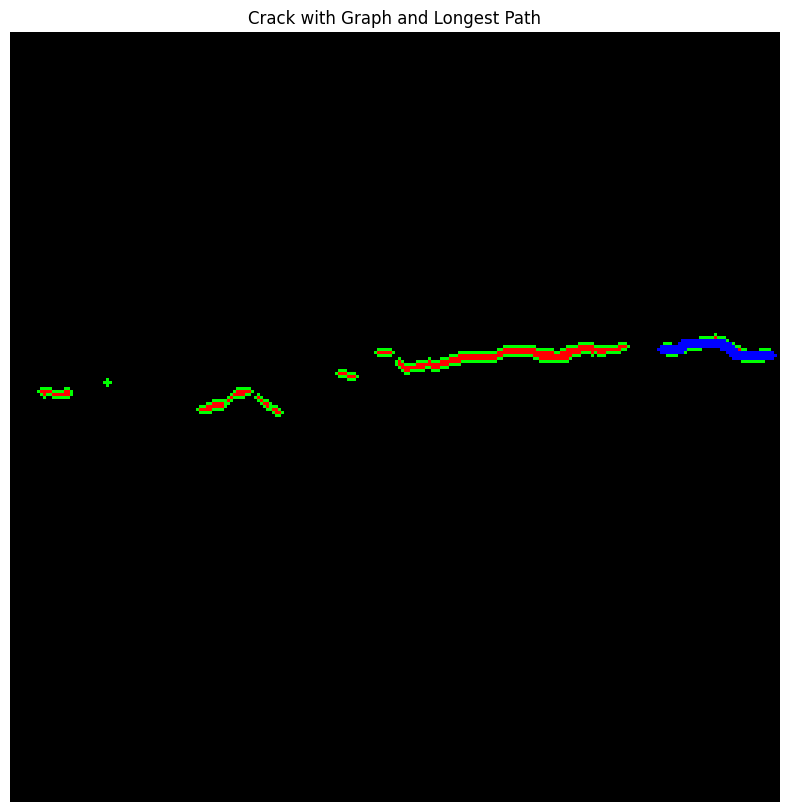

Estimated Crack Length: 39.49 pixels
Estimated Average Crack Width: 9.63 pixels
--------------------------------------------------
Processing image: 11296-3_meta_ensemble_prediction.png


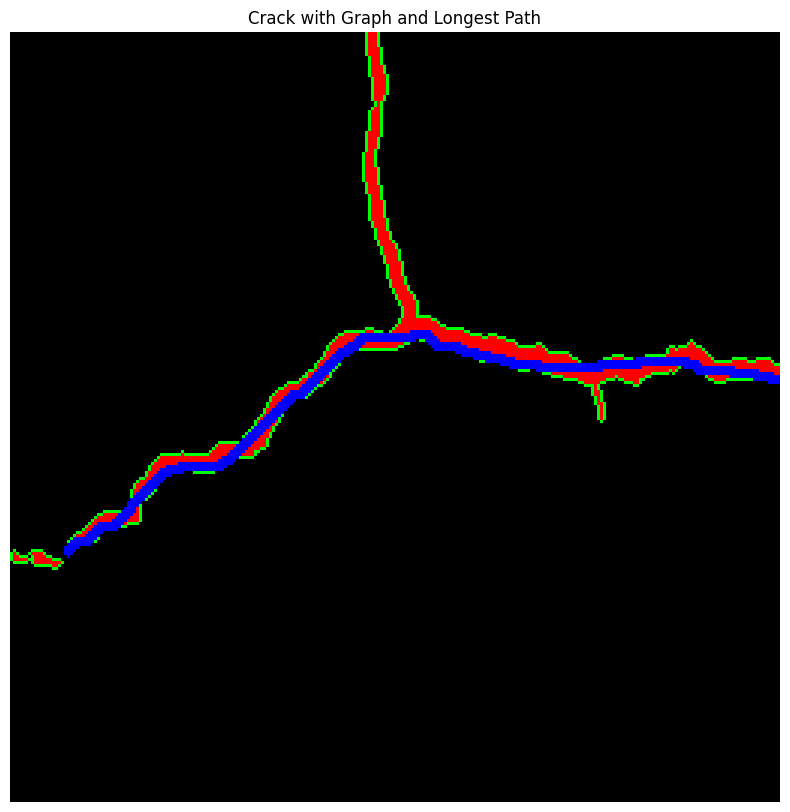

Estimated Crack Length: 275.28 pixels
Estimated Average Crack Width: 16.27 pixels
--------------------------------------------------
Processing image: 11113_meta_ensemble_prediction.png


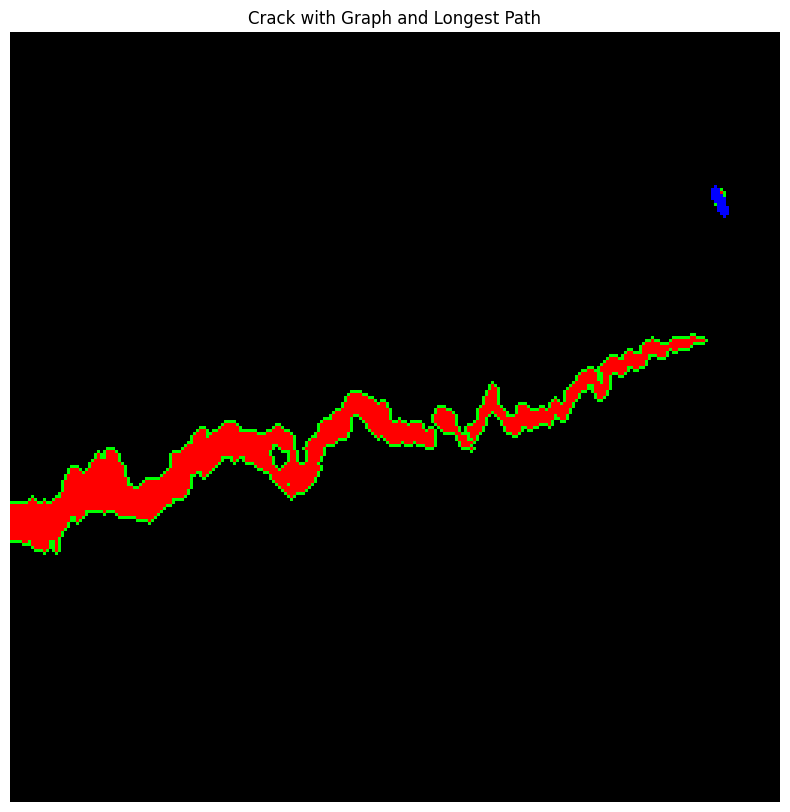

Estimated Crack Length: 9.24 pixels
Estimated Average Crack Width: 18.02 pixels
--------------------------------------------------
Processing image: 11215-4_meta_ensemble_prediction.png


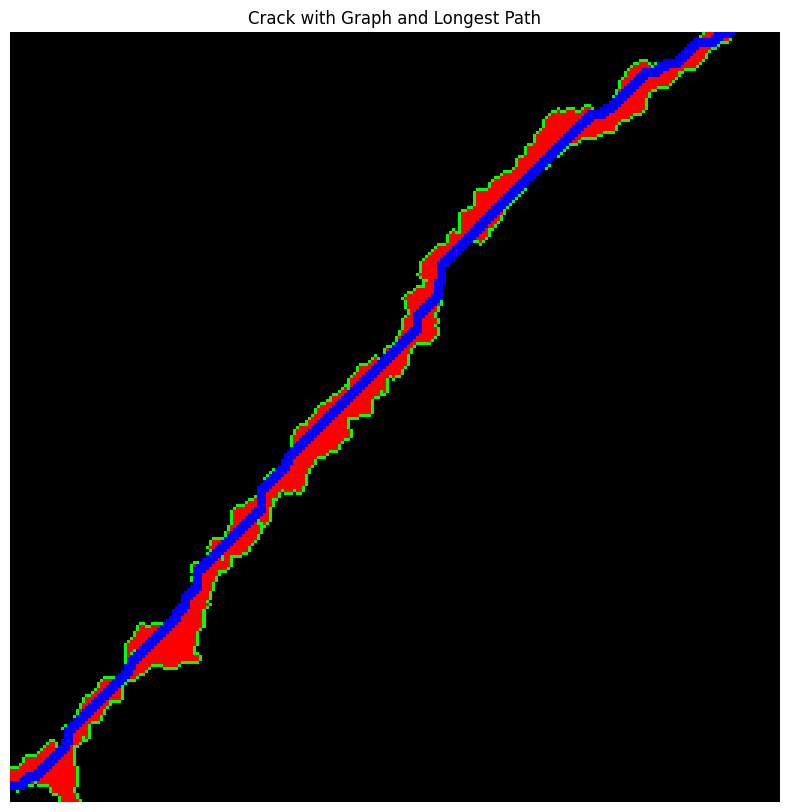

Estimated Crack Length: 363.06 pixels
Estimated Average Crack Width: 13.08 pixels
--------------------------------------------------
Processing image: 11247-1_meta_ensemble_prediction.png


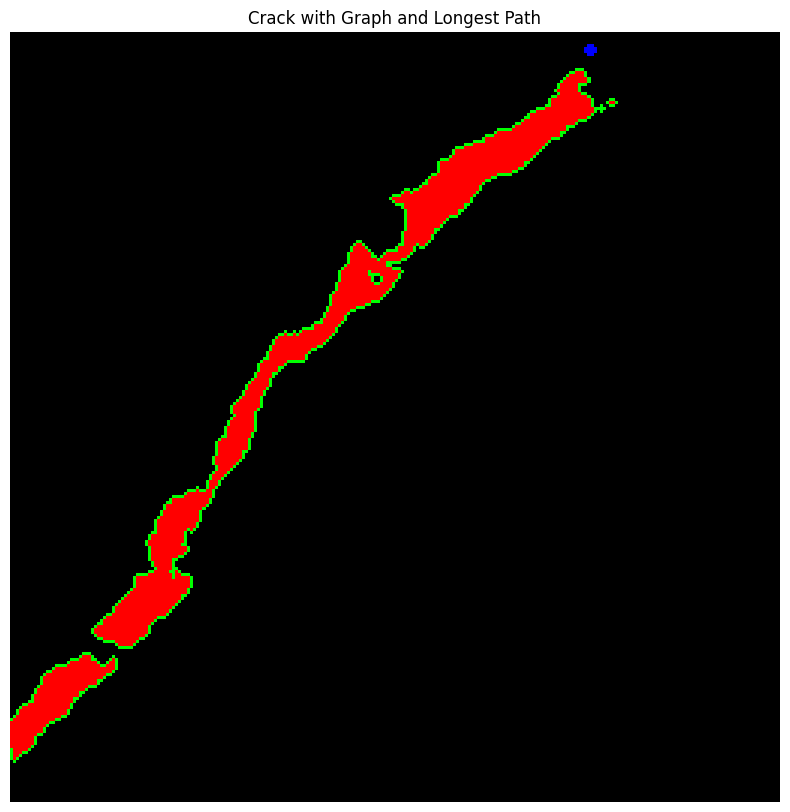

Estimated Crack Length: 1.41 pixels
Estimated Average Crack Width: 15.01 pixels
--------------------------------------------------
Processing image: 11302-2_meta_ensemble_prediction.png


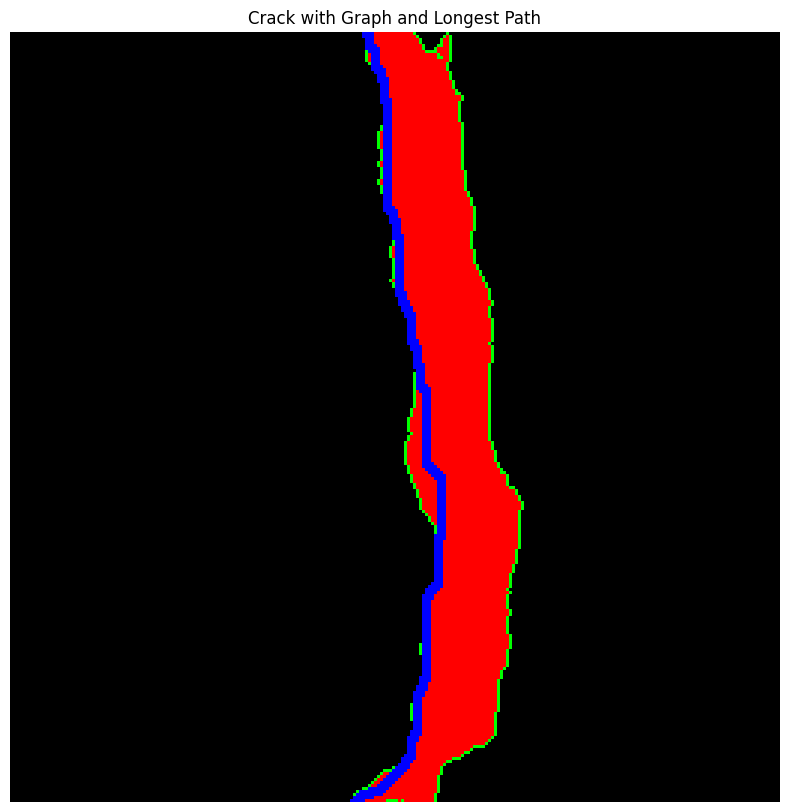

Estimated Crack Length: 280.30 pixels
Estimated Average Crack Width: 26.16 pixels
--------------------------------------------------
Processing image: 11133_meta_ensemble_prediction.png


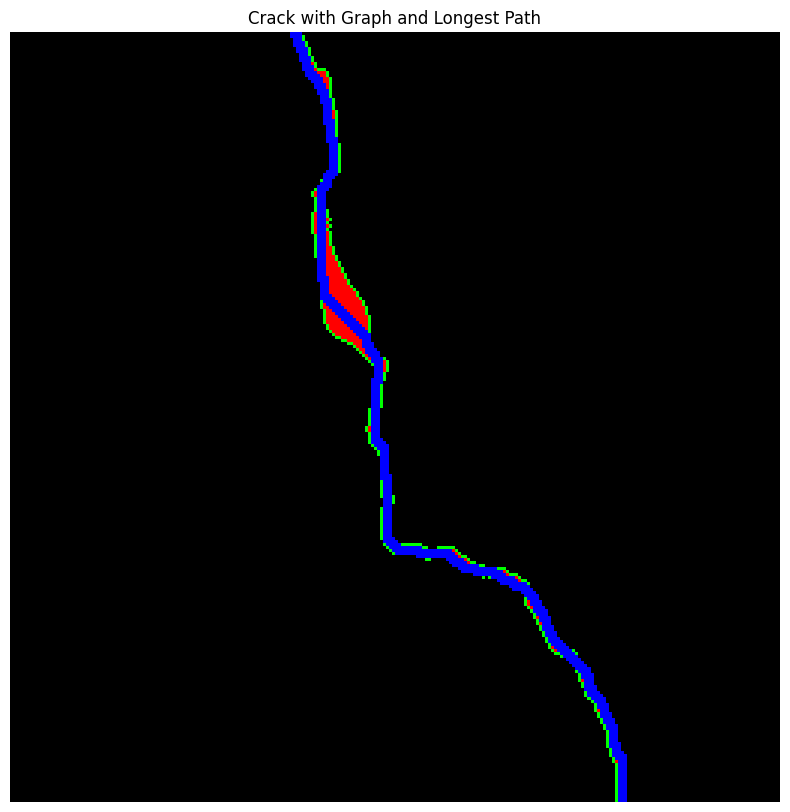

Estimated Crack Length: 321.28 pixels
Estimated Average Crack Width: 6.00 pixels
--------------------------------------------------
Processing image: 11190-6_meta_ensemble_prediction.png


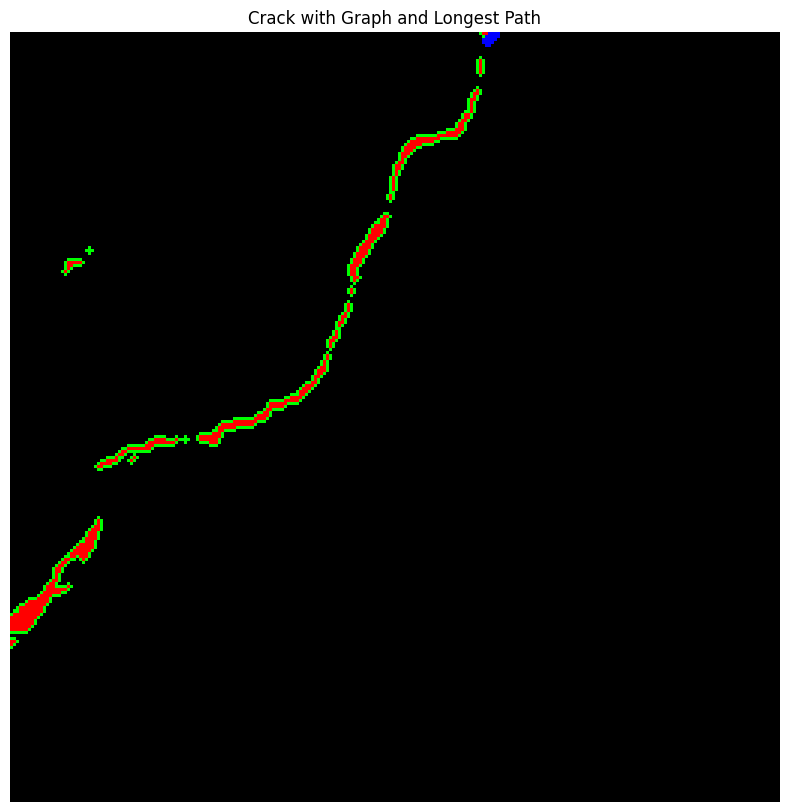

Estimated Crack Length: 4.24 pixels
Estimated Average Crack Width: 4.59 pixels
--------------------------------------------------
Processing image: 11158_meta_ensemble_prediction.png


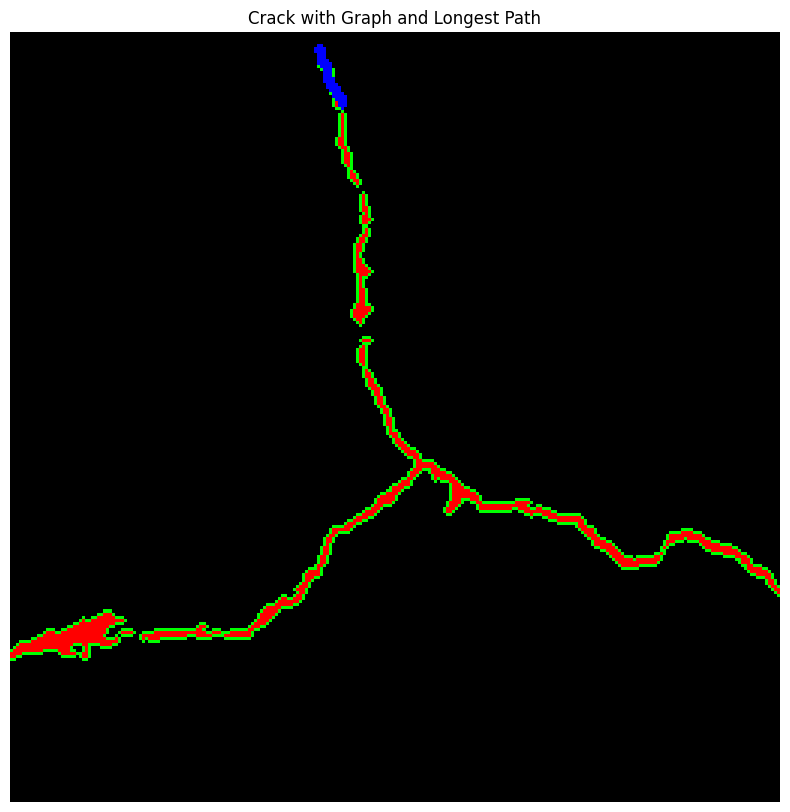

Estimated Crack Length: 22.31 pixels
Estimated Average Crack Width: 7.31 pixels
--------------------------------------------------
Processing image: 7Q3A9064-17_meta_ensemble_prediction.png


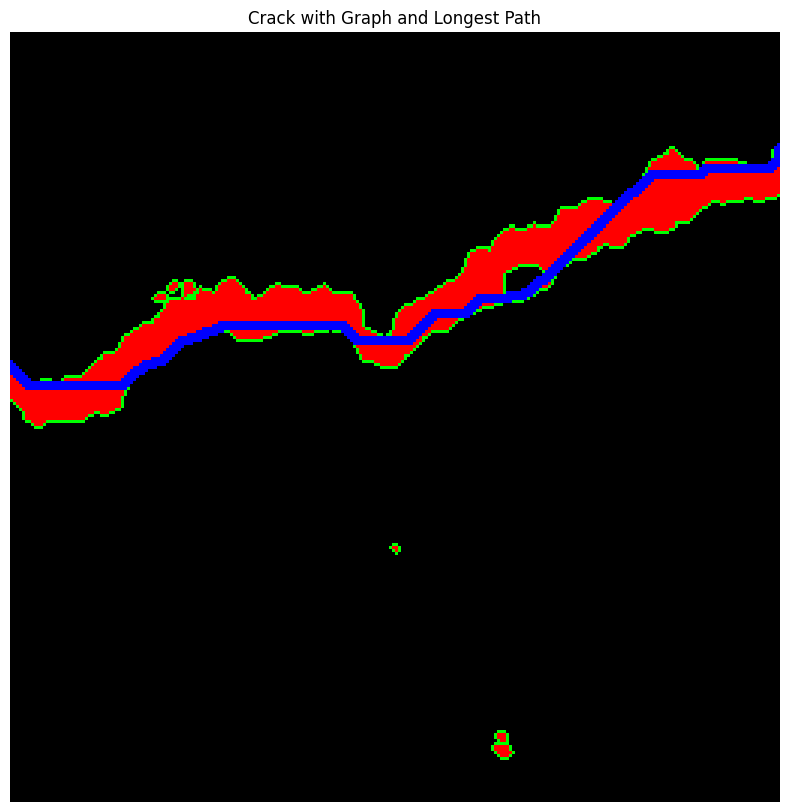

Estimated Crack Length: 297.69 pixels
Estimated Average Crack Width: 34.84 pixels
--------------------------------------------------
Processing image: 11116-2_meta_ensemble_prediction.png


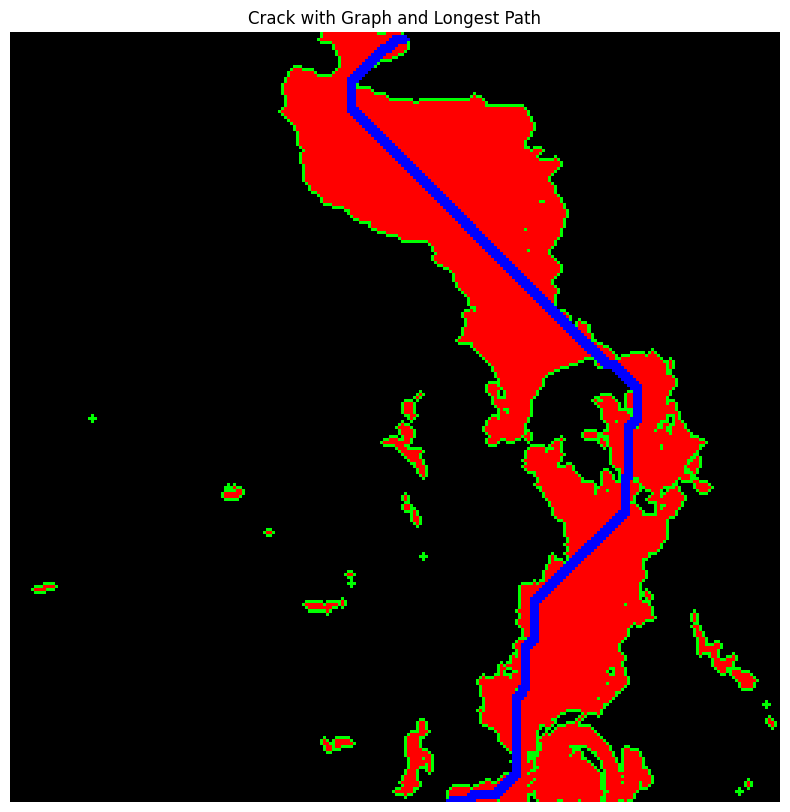

Estimated Crack Length: 336.62 pixels
Estimated Average Crack Width: 40.90 pixels
--------------------------------------------------
Processing image: 11166-2_meta_ensemble_prediction.png


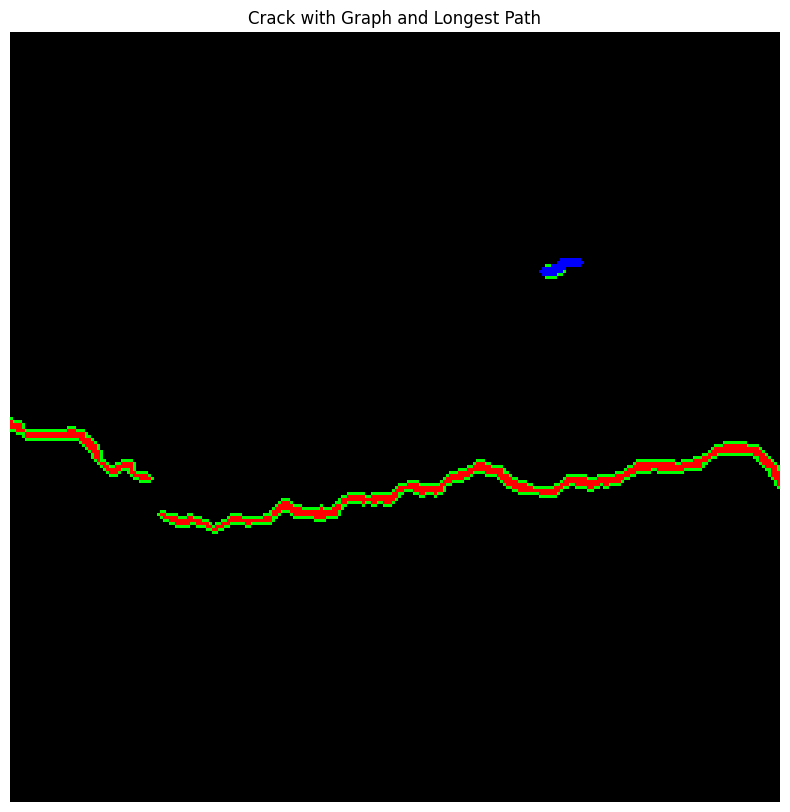

Estimated Crack Length: 13.24 pixels
Estimated Average Crack Width: 9.53 pixels
--------------------------------------------------
Processing image: 11193-1_meta_ensemble_prediction.png


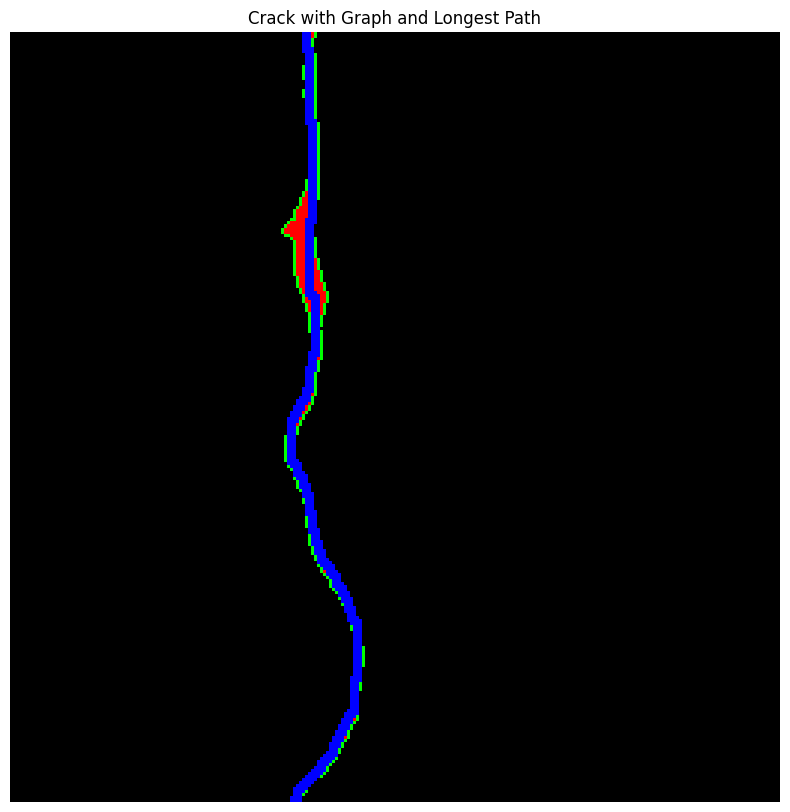

Estimated Crack Length: 278.20 pixels
Estimated Average Crack Width: 3.91 pixels
--------------------------------------------------
Processing image: 11305-2_meta_ensemble_prediction.png


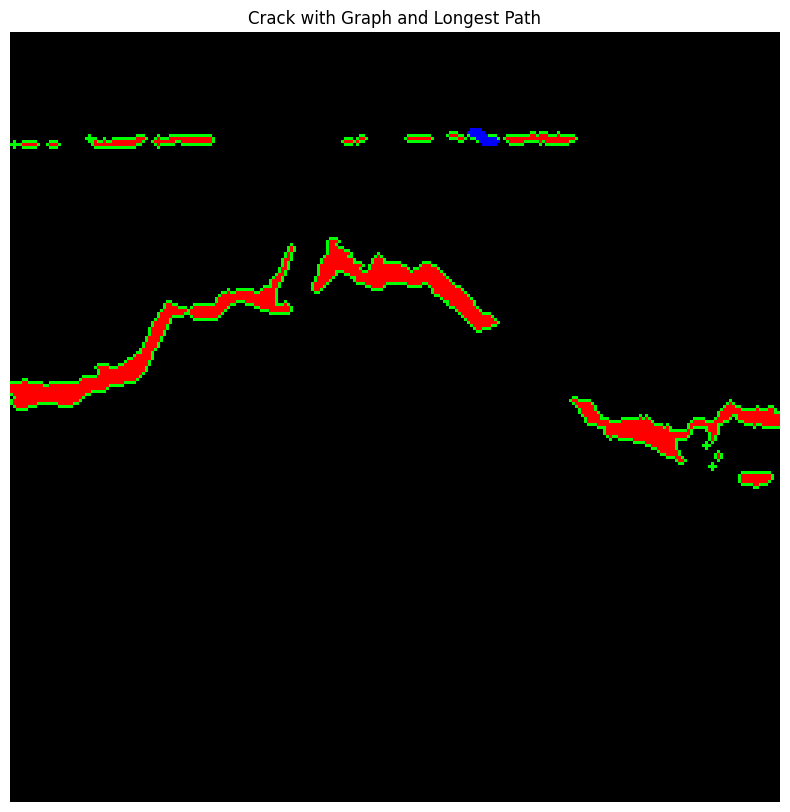

Estimated Crack Length: 9.24 pixels
Estimated Average Crack Width: 13.03 pixels
--------------------------------------------------
Processing image: IMG39-2_meta_ensemble_prediction.png


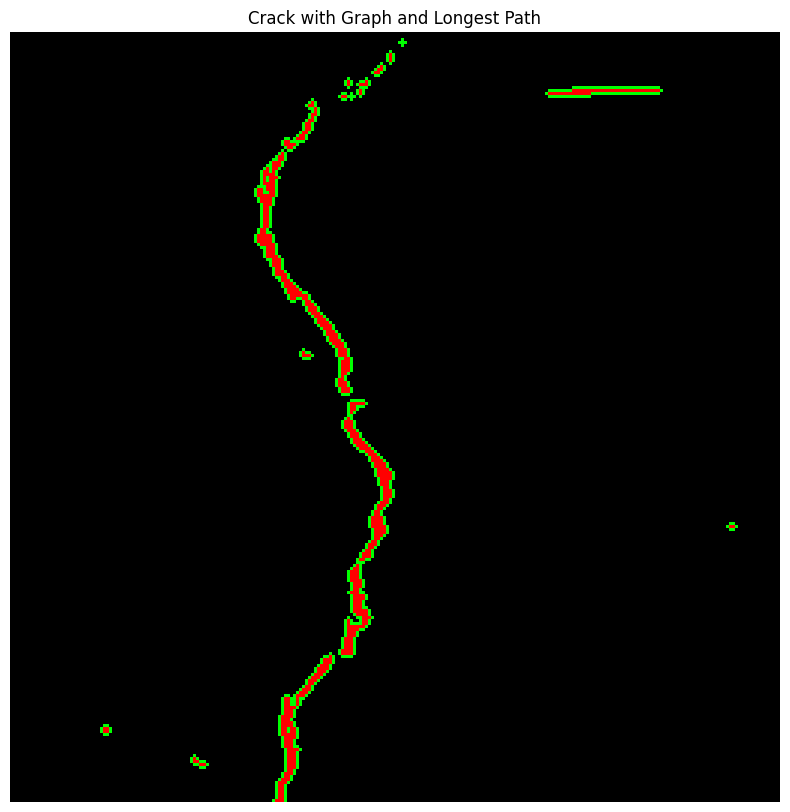

Estimated Crack Length: 0.00 pixels
Estimated Average Crack Width: 4.33 pixels
--------------------------------------------------
Processing image: IMG_6537-5_meta_ensemble_prediction.png


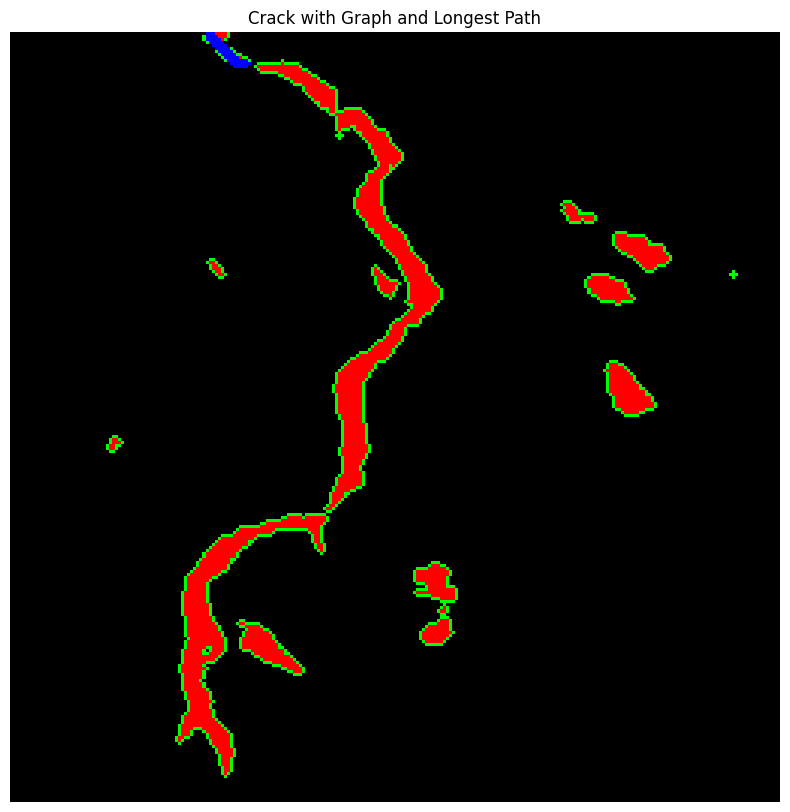

Estimated Crack Length: 16.73 pixels
Estimated Average Crack Width: 8.47 pixels
--------------------------------------------------
Processing image: 11304_meta_ensemble_prediction.png


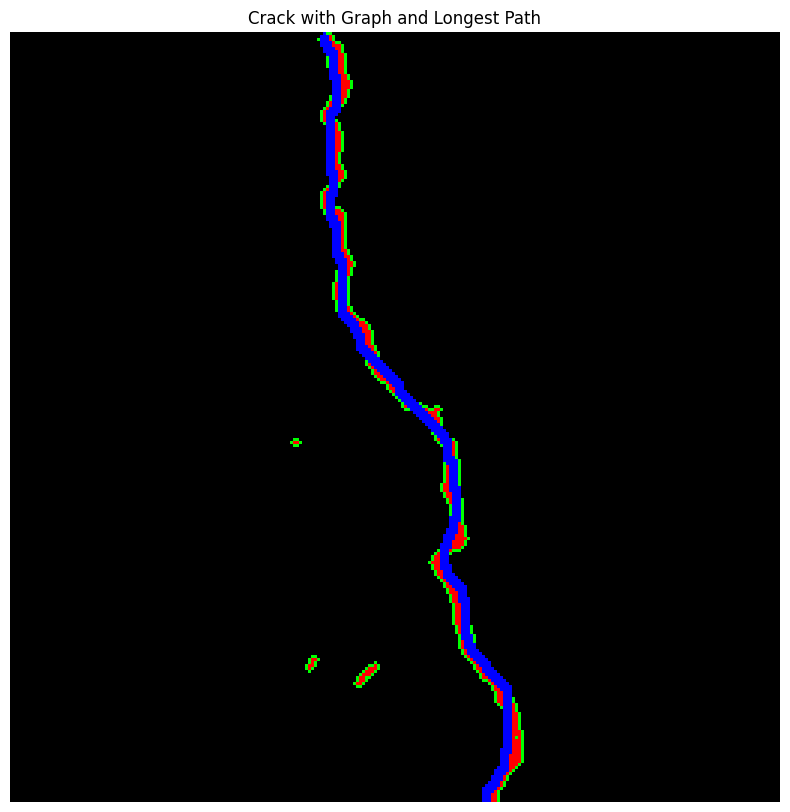

Estimated Crack Length: 287.97 pixels
Estimated Average Crack Width: 4.20 pixels
--------------------------------------------------
Processing image: 11247-12_meta_ensemble_prediction.png


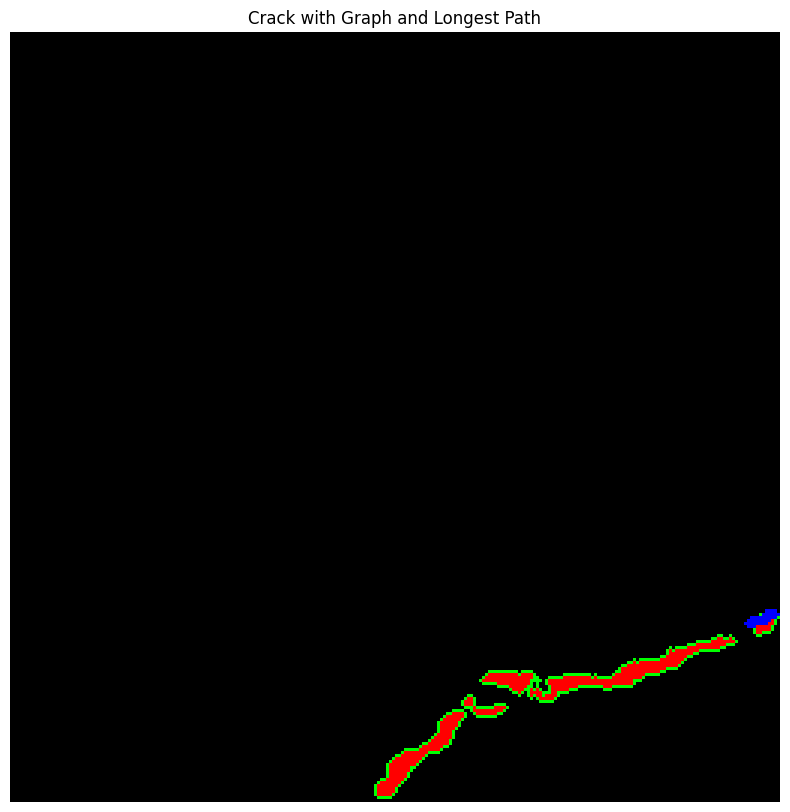

Estimated Crack Length: 10.24 pixels
Estimated Average Crack Width: 10.38 pixels
--------------------------------------------------
Processing image: 11159_meta_ensemble_prediction.png


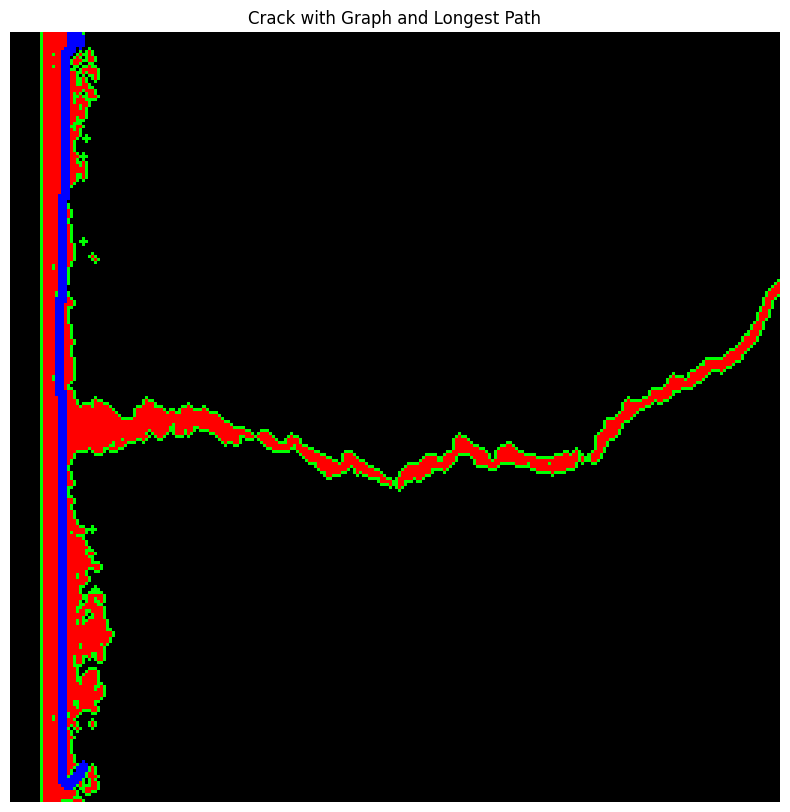

Estimated Crack Length: 267.21 pixels
Estimated Average Crack Width: 12.64 pixels
--------------------------------------------------
Processing image: 11163_meta_ensemble_prediction.png


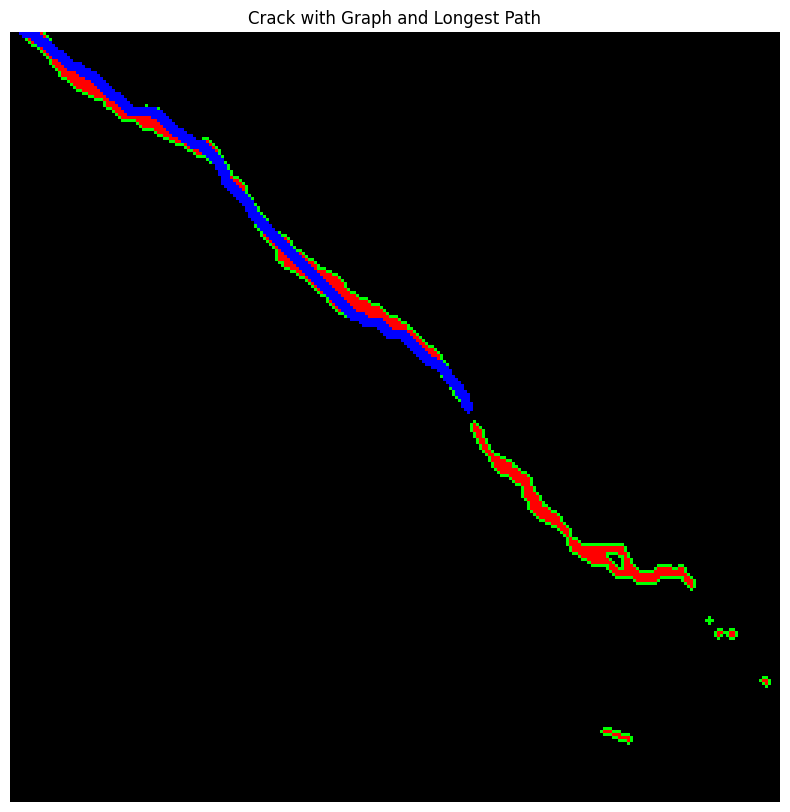

Estimated Crack Length: 206.22 pixels
Estimated Average Crack Width: 8.32 pixels
--------------------------------------------------
Processing image: 11156_meta_ensemble_prediction.png


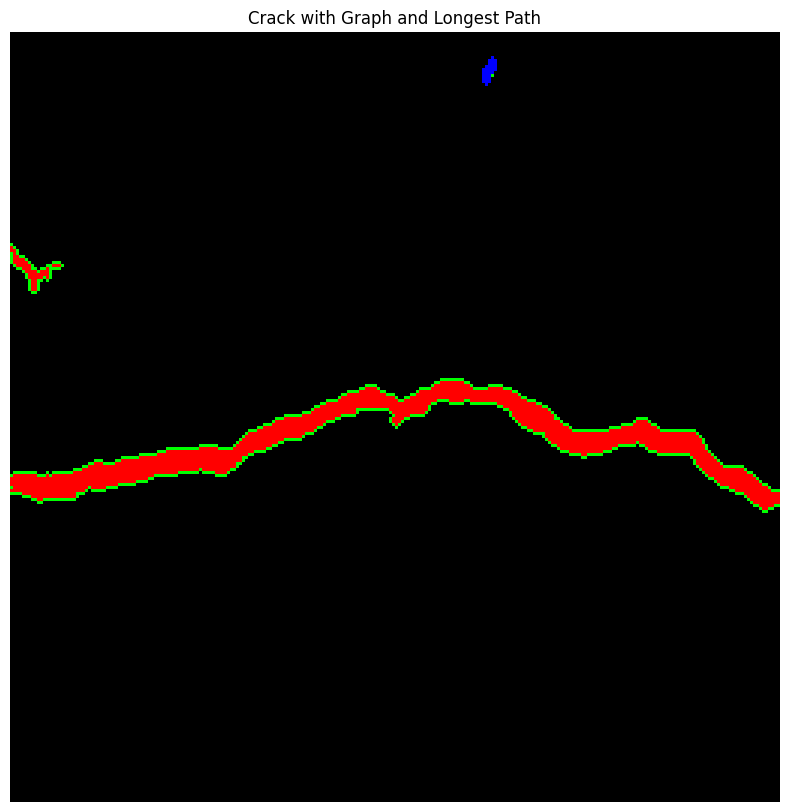

Estimated Crack Length: 7.83 pixels
Estimated Average Crack Width: 24.95 pixels
--------------------------------------------------
Processing image: IMG_6469-7_meta_ensemble_prediction.png


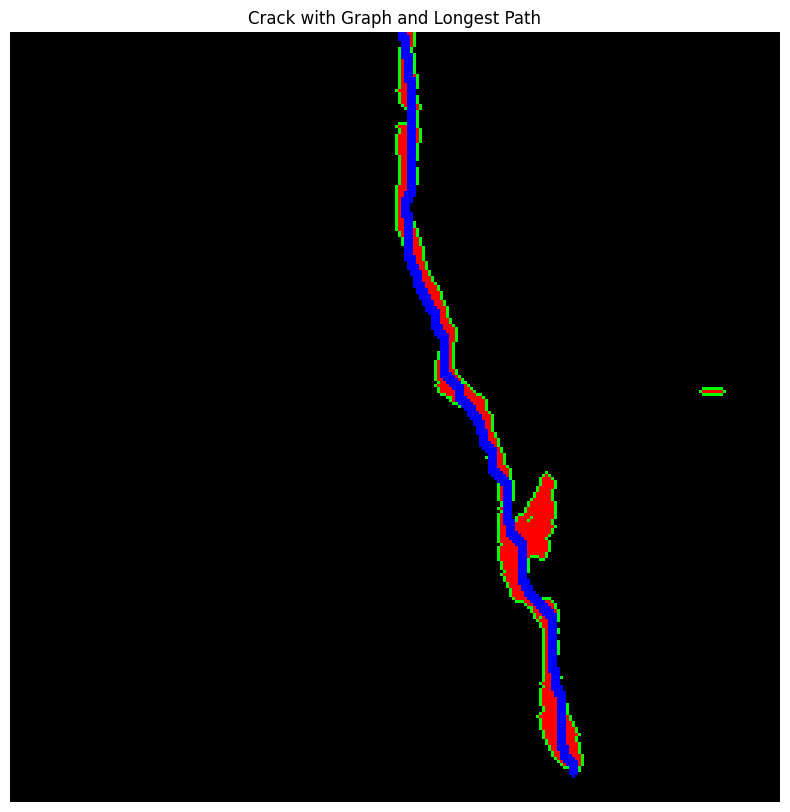

Estimated Crack Length: 271.27 pixels
Estimated Average Crack Width: 6.92 pixels
--------------------------------------------------
Processing image: 11231-6_meta_ensemble_prediction.png


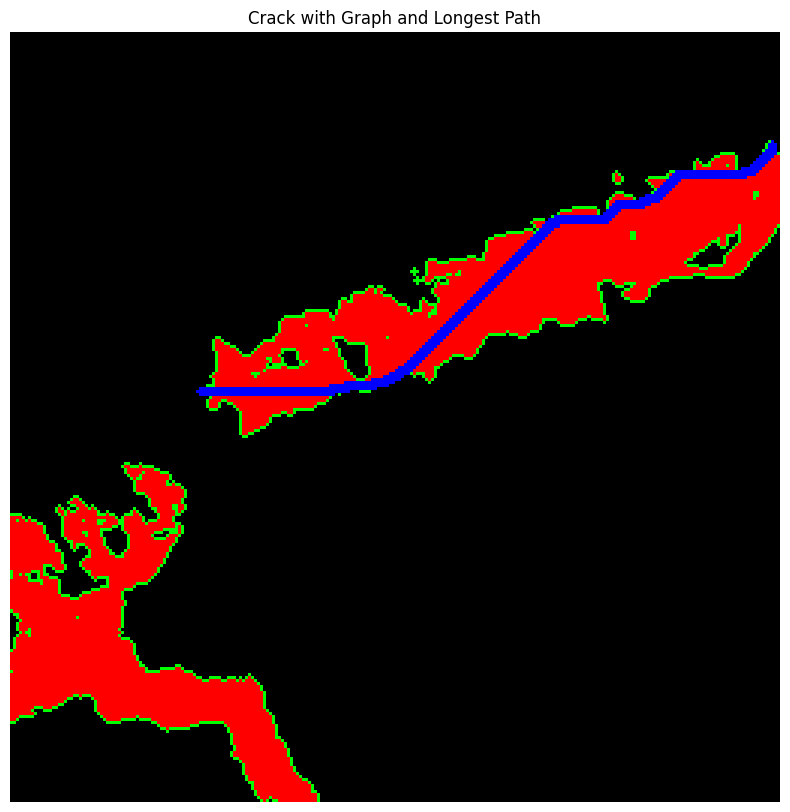

Estimated Crack Length: 225.14 pixels
Estimated Average Crack Width: 41.87 pixels
--------------------------------------------------
Processing image: 7Q3A9060-6_meta_ensemble_prediction.png


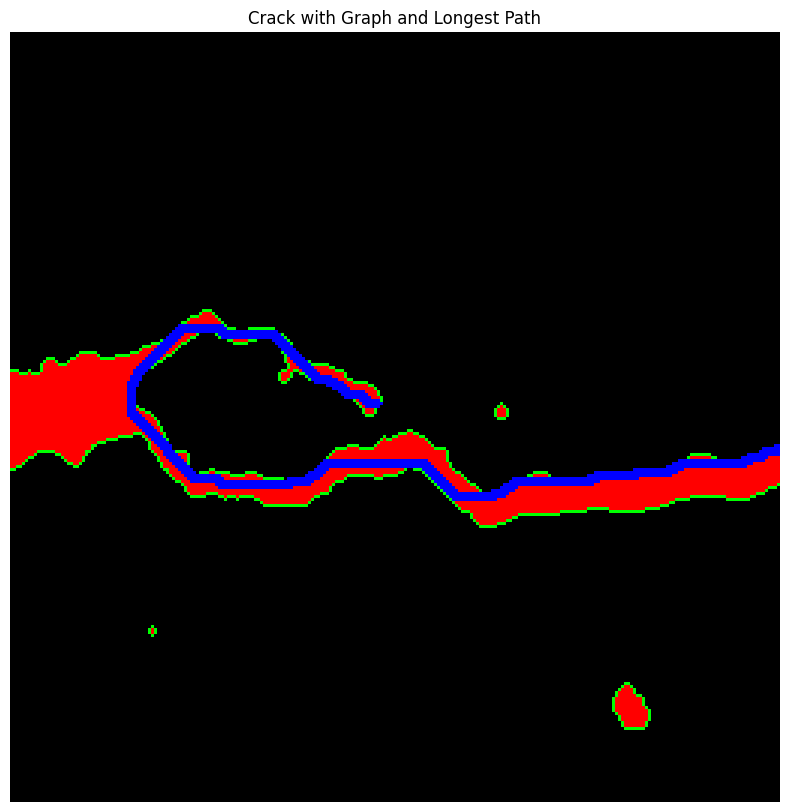

Estimated Crack Length: 350.01 pixels
Estimated Average Crack Width: 39.66 pixels
--------------------------------------------------
Processing image: 11271-3_meta_ensemble_prediction.png


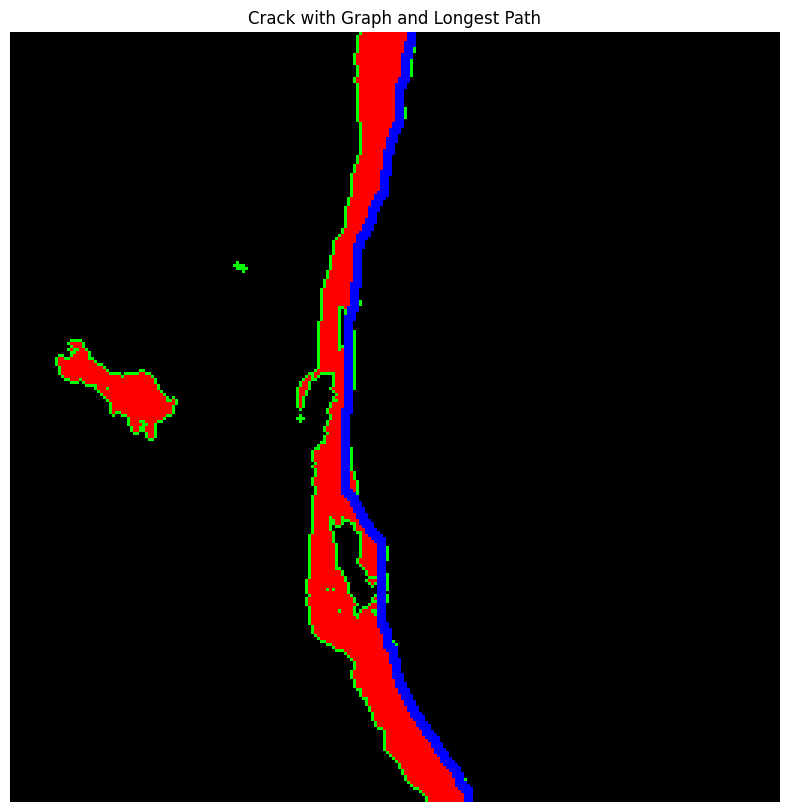

Estimated Crack Length: 281.10 pixels
Estimated Average Crack Width: 13.37 pixels
--------------------------------------------------
Processing image: 11111_meta_ensemble_prediction.png


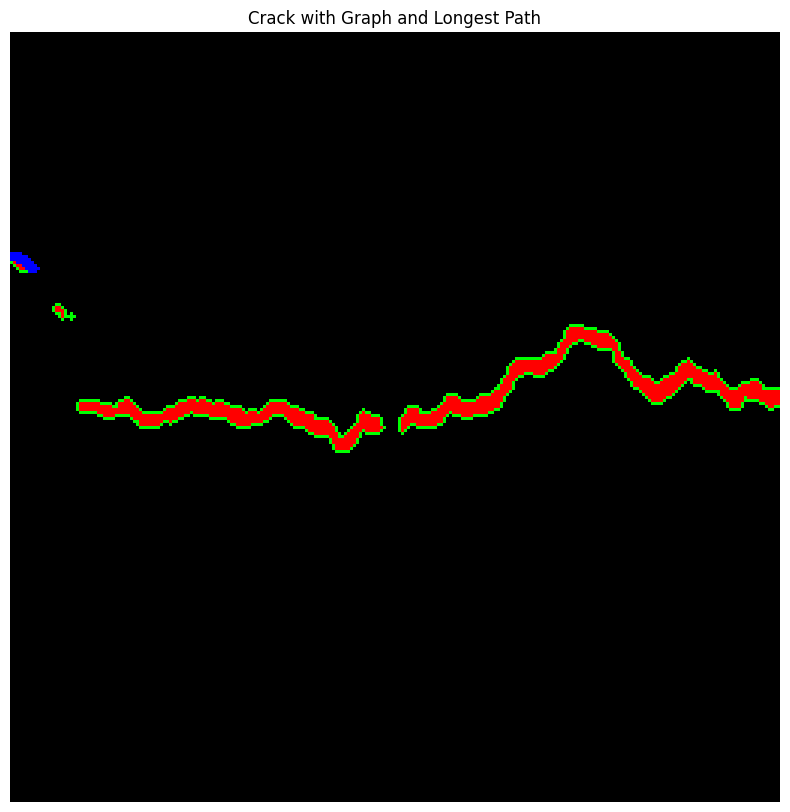

Estimated Crack Length: 9.66 pixels
Estimated Average Crack Width: 11.08 pixels
--------------------------------------------------
Processing image: IMG25-10_meta_ensemble_prediction.png


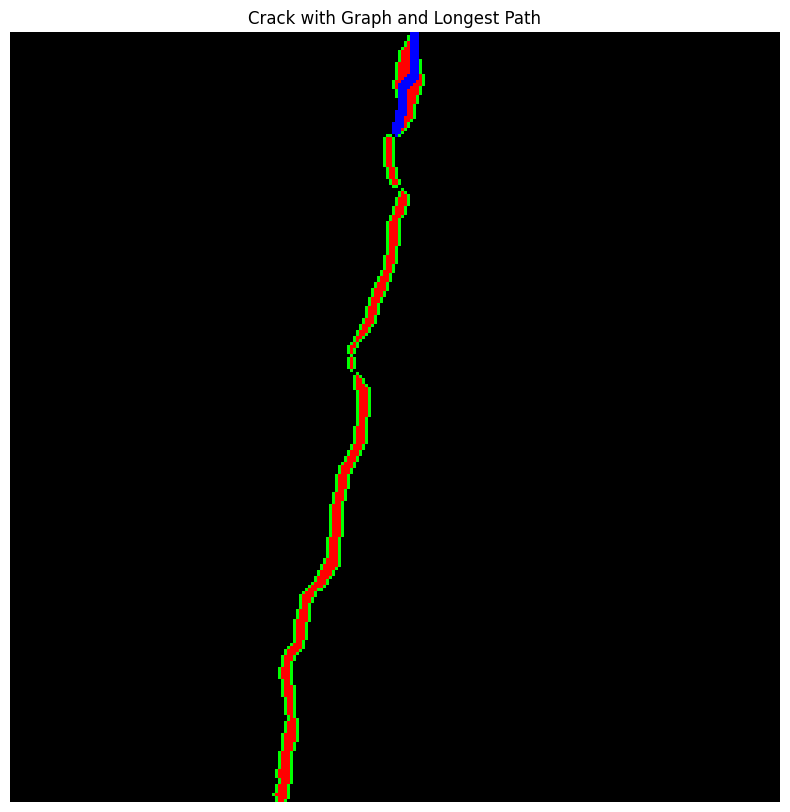

Estimated Crack Length: 35.49 pixels
Estimated Average Crack Width: 3.63 pixels
--------------------------------------------------
Processing image: 11162_meta_ensemble_prediction.png


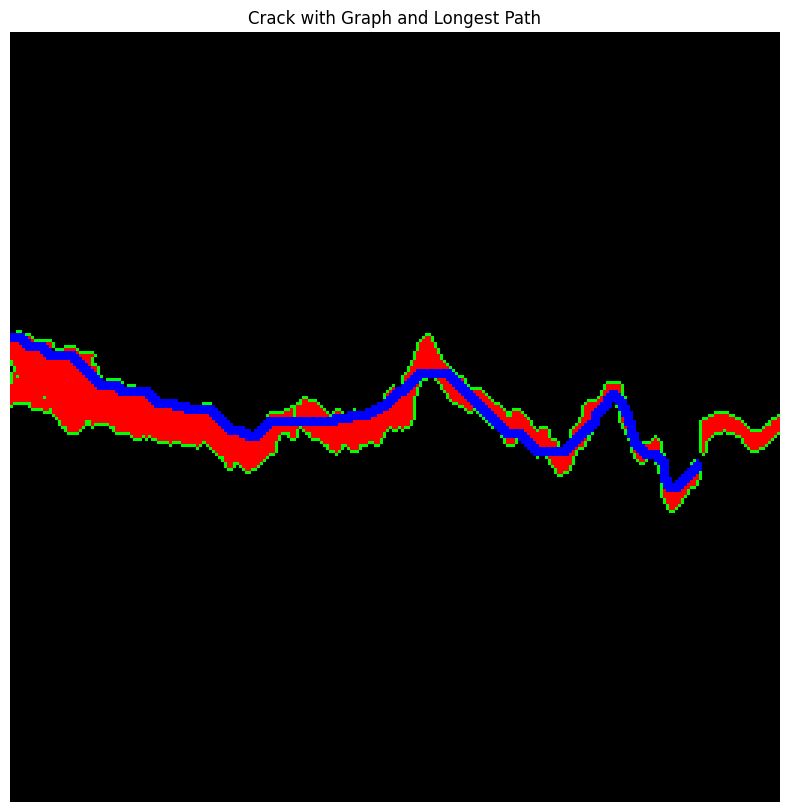

Estimated Crack Length: 296.29 pixels
Estimated Average Crack Width: 24.27 pixels
--------------------------------------------------
Processing image: 11236-3_meta_ensemble_prediction.png


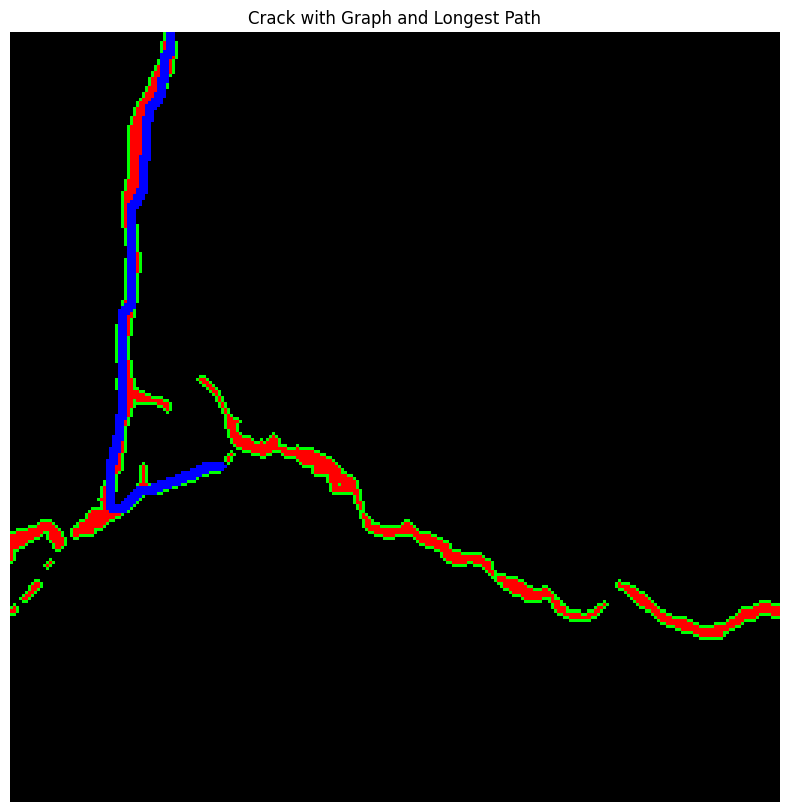

Estimated Crack Length: 208.50 pixels
Estimated Average Crack Width: 6.28 pixels
--------------------------------------------------
Processing image: 11248-3_meta_ensemble_prediction.png


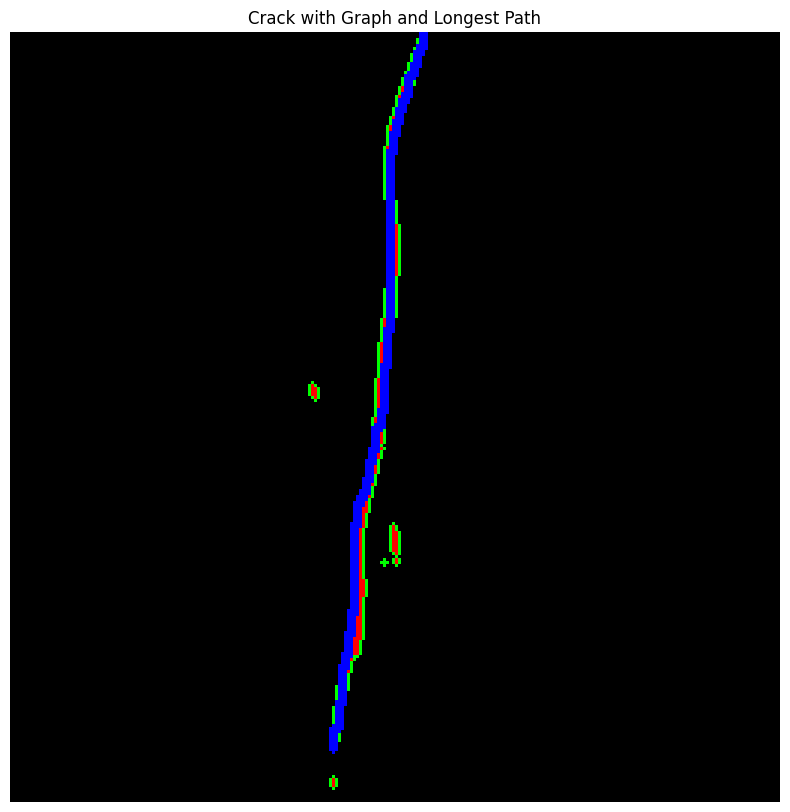

Estimated Crack Length: 250.43 pixels
Estimated Average Crack Width: 2.83 pixels
--------------------------------------------------
Processing image: 11239-3_meta_ensemble_prediction.png


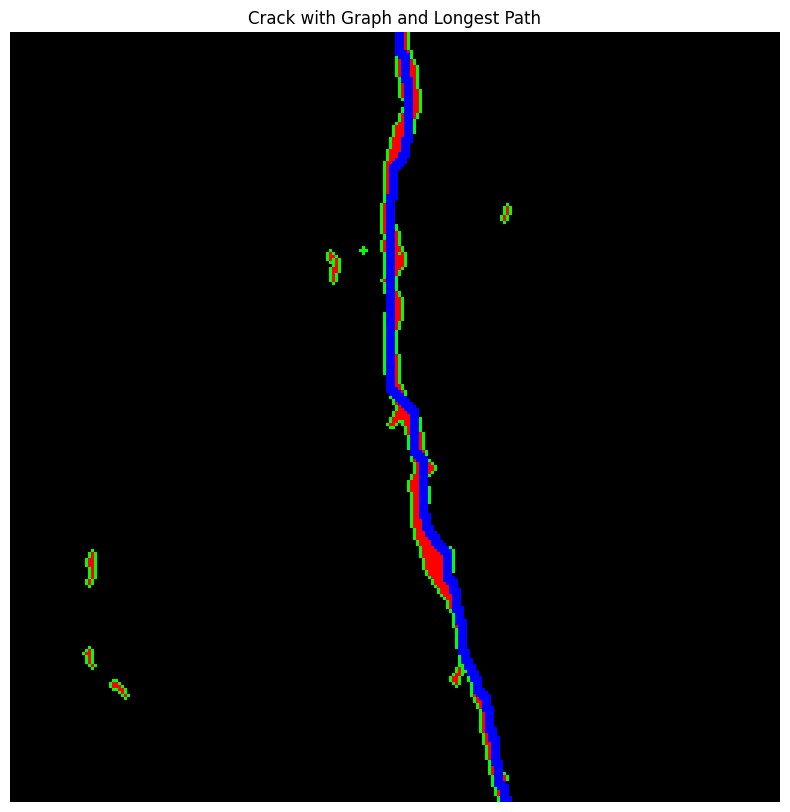

Estimated Crack Length: 274.88 pixels
Estimated Average Crack Width: 4.55 pixels
--------------------------------------------------
Processing image: 11123-2_meta_ensemble_prediction.png


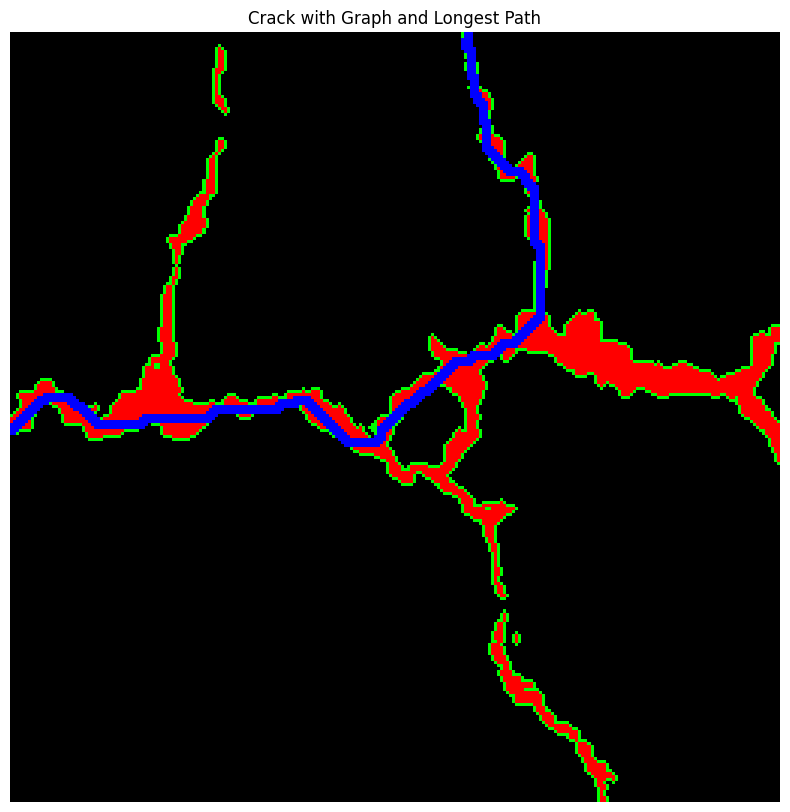

Estimated Crack Length: 318.49 pixels
Estimated Average Crack Width: 15.50 pixels
--------------------------------------------------
Processing image: 11179-4_meta_ensemble_prediction.png


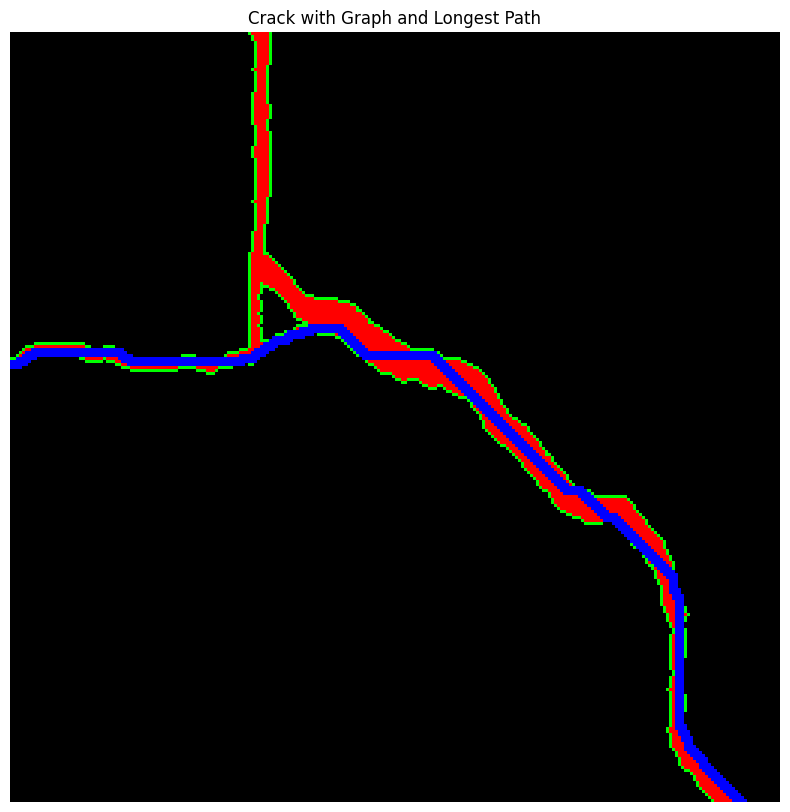

Estimated Crack Length: 345.95 pixels
Estimated Average Crack Width: 14.55 pixels
--------------------------------------------------
Processing image: 11165-1_meta_ensemble_prediction.png


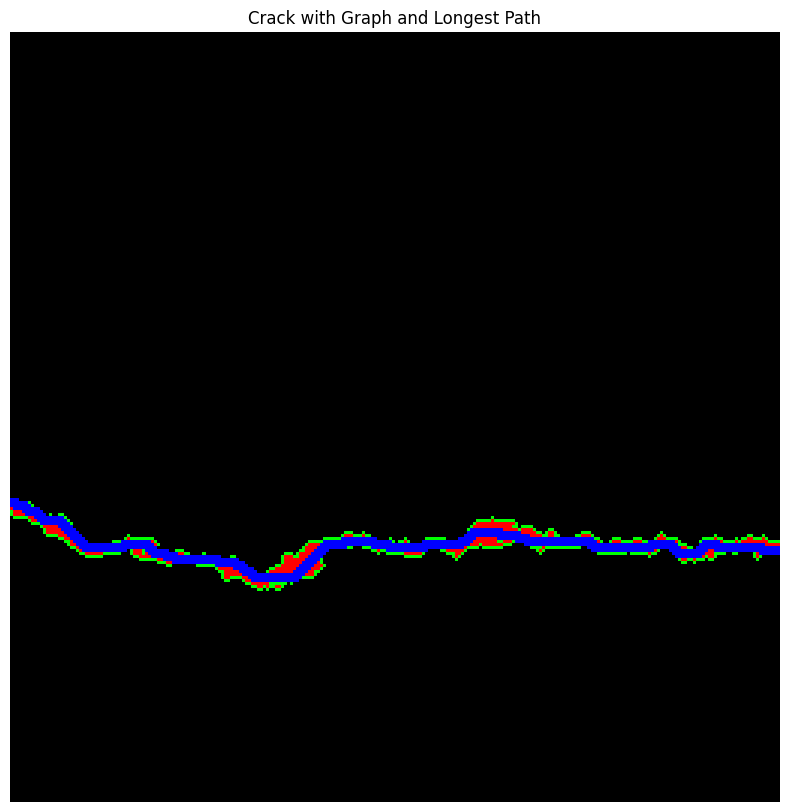

Estimated Crack Length: 279.85 pixels
Estimated Average Crack Width: 12.05 pixels
--------------------------------------------------
Processing image: 11156-1_meta_ensemble_prediction.png


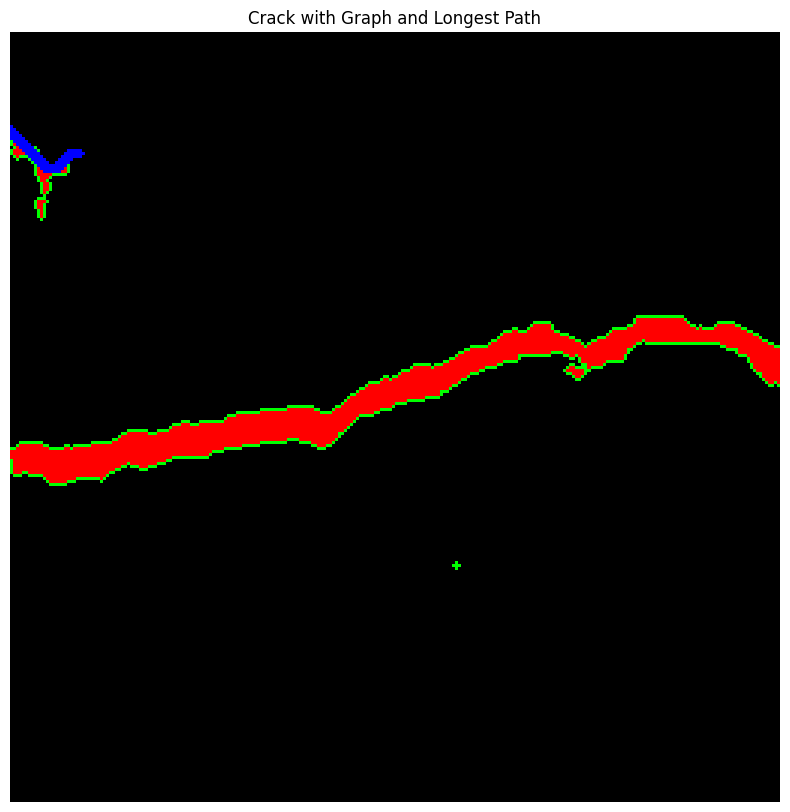

Estimated Crack Length: 31.04 pixels
Estimated Average Crack Width: 34.61 pixels
--------------------------------------------------
Processing image: IMG_6522-1_meta_ensemble_prediction.png


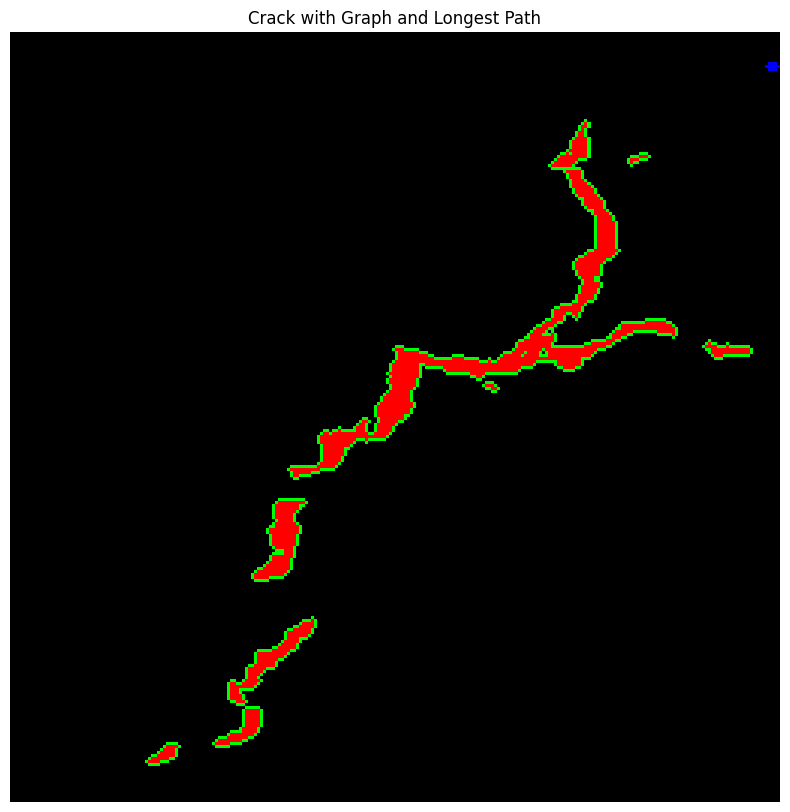

Estimated Crack Length: 2.00 pixels
Estimated Average Crack Width: 9.67 pixels
--------------------------------------------------
Processing image: 11215-6_meta_ensemble_prediction.png


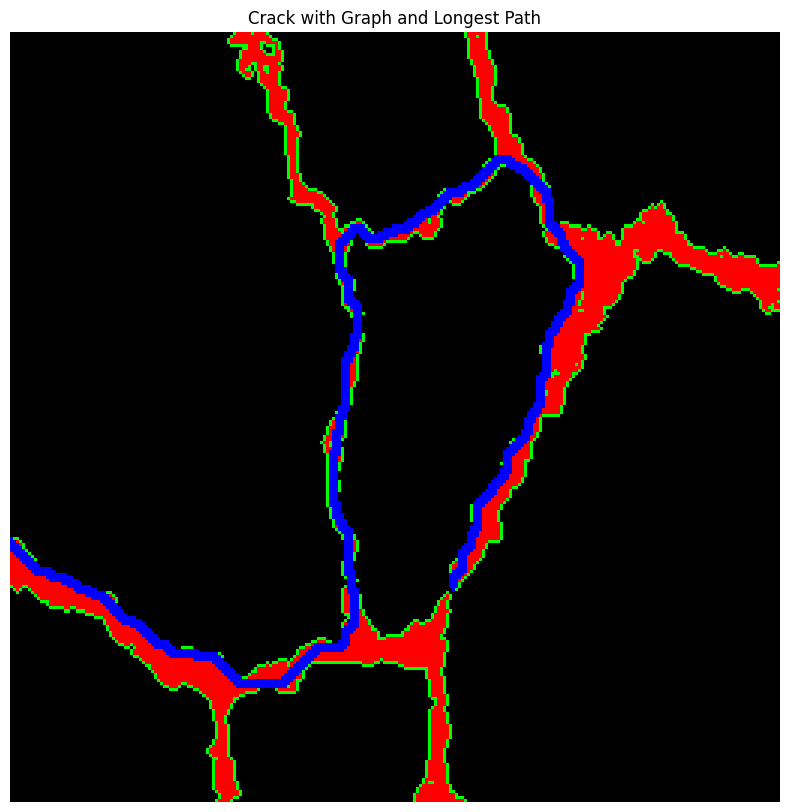

Estimated Crack Length: 519.39 pixels
Estimated Average Crack Width: 13.49 pixels
--------------------------------------------------
Processing image: IMG27-4_meta_ensemble_prediction.png


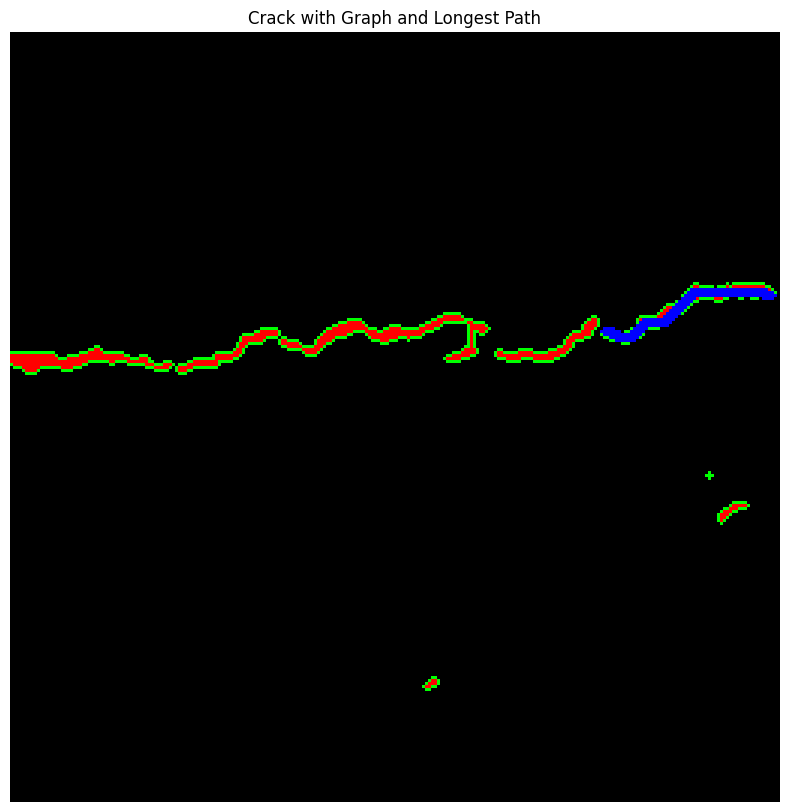

Estimated Crack Length: 63.46 pixels
Estimated Average Crack Width: 10.34 pixels
--------------------------------------------------
Processing image: 11192-2_meta_ensemble_prediction.png


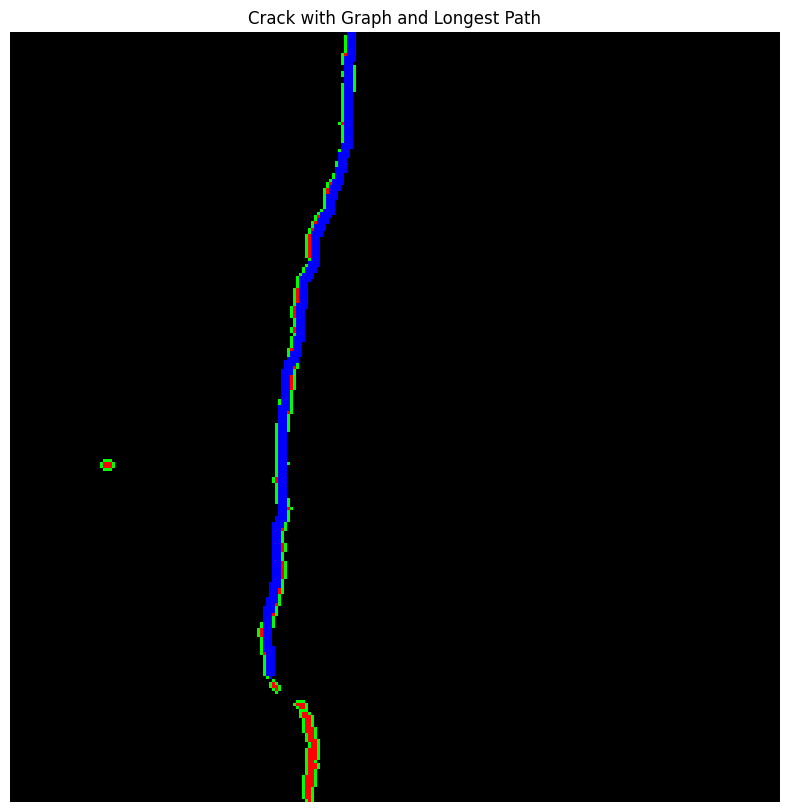

Estimated Crack Length: 225.01 pixels
Estimated Average Crack Width: 2.54 pixels
--------------------------------------------------
Processing image: 11296-20_meta_ensemble_prediction.png


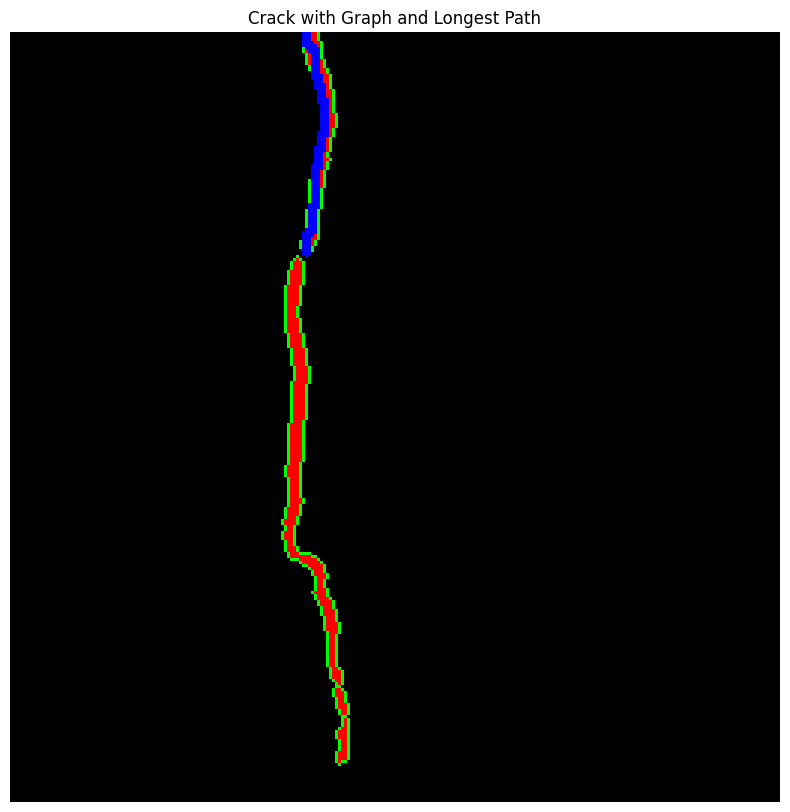

Estimated Crack Length: 77.97 pixels
Estimated Average Crack Width: 3.65 pixels
--------------------------------------------------
Processing image: 11289-3_meta_ensemble_prediction.png


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-51d9ed080d44>", line 122, in <cell line: 0>
    process_images_in_folder(folder_path)
  File "<ipython-input-3-51d9ed080d44>", line 104, in process_images_in_folder
    G = skeleton_to_graph(skeleton_binary)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-3-51d9ed080d44>", line None, in skeleton_to_graph
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:


In [ ]:
import os
import numpy as np
import cv2
import networkx as nx
import matplotlib.pyplot as plt

def skeleton_to_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape

    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),          (0, 1),
                  (1, -1),  (1, 0), (1, 1)]

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                G.add_node((x, y))
                for dx, dy in directions:
                    nx_, ny_ = x + dx, y + dy
                    if 0 <= nx_ < rows and 0 <= ny_ < cols and skeleton[nx_, ny_] == 1:
                        if abs(dx) + abs(dy) == 2:
                            weight = np.sqrt(2)
                        else:
                            weight = 1
                        G.add_edge((x, y), (nx_, ny_), weight=weight)
    return G

def find_longest_path(G):
    start_node = list(G.nodes())[0]
    lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='weight')
    farthest_node = max(lengths, key=lengths.get)

    lengths = nx.single_source_dijkstra_path_length(G, farthest_node, weight='weight')
    other_farthest_node = max(lengths, key=lengths.get)

    path = nx.shortest_path(G, source=farthest_node, target=other_farthest_node, weight='weight')

    crack_length = 0
    for i in range(len(path)-1):
        crack_length += G[path[i]][path[i+1]]['weight']

    return crack_length, path

def estimate_crack_width(skeleton):
    widths = []
    rows, cols = skeleton.shape

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                # Move horizontally to left and right (easy approx)
                left, right = 0, 0
                while y - left - 1 >= 0 and skeleton[x, y - left - 1] == 1:
                    left += 1
                while y + right + 1 < cols and skeleton[x, y + right + 1] == 1:
                    right += 1
                local_width = left + right + 1  # include center pixel
                widths.append(local_width)

    if widths:
        avg_width = np.mean(widths)
    else:
        avg_width = 0
    return avg_width

def visualize_crack_and_graph(original_img, skeleton, G, longest_path):
    vis_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)

    # Draw all nodes
    for (x, y) in G.nodes():
        cv2.circle(vis_img, (y, x), 1, (0, 255, 0), -1)

    # Draw all edges
    for (u, v) in G.edges():
        cv2.line(vis_img, (u[1], u[0]), (v[1], v[0]), (255, 0, 0), 1)

    # Highlight the longest path
    for i in range(len(longest_path) - 1):
        u, v = longest_path[i], longest_path[i+1]
        cv2.line(vis_img, (u[1], u[0]), (v[1], v[0]), (0, 0, 255), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img)
    plt.axis('off')
    plt.title("Crack with Graph and Longest Path")
    plt.show()

# Function to process all images in a folder
def process_images_in_folder(folder_path):
    # List all files in the folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Only process image files (you can modify this filter as needed)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Processing image: {file_name}")

            # Load the skeletonized image
            skeleton_img = cv2.imread(file_path, 0)
            _, skeleton_binary = cv2.threshold(skeleton_img, 127, 1, cv2.THRESH_BINARY)

            # Build the graph
            G = skeleton_to_graph(skeleton_binary)

            # Find the longest crack path
            crack_length, longest_path = find_longest_path(G)

            # Estimate crack width
            crack_width = estimate_crack_width(skeleton_binary)

            # Visualize everything
            visualize_crack_and_graph(skeleton_img, skeleton_binary, G, longest_path)

            # Print results
            print(f"Estimated Crack Length: {crack_length:.2f} pixels")
            print(f"Estimated Average Crack Width: {crack_width:.2f} pixels")
            print("-" * 50)

# Example usage
folder_path = '/content/drive/MyDrive/Crack Segmentaion/DeepCrack/meta_ensemble'  # Replace with your folder path
process_images_in_folder(folder_path)


In [ ]:
import os
import numpy as np
import cv2
import networkx as nx

# Function to convert skeleton to graph
def skeleton_to_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape

    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),          (0, 1),
                  (1, -1),  (1, 0), (1, 1)]

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                G.add_node((x, y))
                for dx, dy in directions:
                    nx_, ny_ = x + dx, y + dy
                    if 0 <= nx_ < rows and 0 <= ny_ < cols and skeleton[nx_, ny_] == 1:
                        if abs(dx) + abs(dy) == 2:
                            weight = np.sqrt(2)
                        else:
                            weight = 1
                        G.add_edge((x, y), (nx_, ny_), weight=weight)
    return G

# Function to find the longest crack path in the graph
def find_longest_path(G):
    start_node = list(G.nodes())[0]
    lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='weight')
    farthest_node = max(lengths, key=lengths.get)

    lengths = nx.single_source_dijkstra_path_length(G, farthest_node, weight='weight')
    other_farthest_node = max(lengths, key=lengths.get)

    path = nx.shortest_path(G, source=farthest_node, target=other_farthest_node, weight='weight')

    crack_length = 0
    for i in range(len(path)-1):
        crack_length += G[path[i]][path[i+1]]['weight']

    return crack_length, path

# Function to estimate the crack width (min, avg, max)
def estimate_crack_width(skeleton):
    min_widths = []
    max_widths = []
    total_widths = []
    rows, cols = skeleton.shape

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                # Move horizontally to left and right (easy approx)
                left, right = 0, 0
                while y - left - 1 >= 0 and skeleton[x, y - left - 1] == 1:
                    left += 1
                while y + right + 1 < cols and skeleton[x, y + right + 1] == 1:
                    right += 1
                local_width = left + right + 1  # include center pixel
                total_widths.append(local_width)
                min_widths.append(left)
                max_widths.append(right)

    avg_width = np.mean(total_widths) if total_widths else 0
    min_width = np.mean(min_widths) if min_widths else 0
    max_width = np.mean(max_widths) if max_widths else 0

    return min_width, avg_width, max_width

# Function to calculate relative error
def calculate_relative_error(predicted, ground_truth):
    if ground_truth != 0:
        return (predicted - ground_truth) / ground_truth * 100
    return 0  # If ground truth is 0, error is considered 0

# Function to process all images in the folder
def process_images_in_folder(meta_ensemble_folder, mask_folder):
    errors_length = []
    errors_min_width = []
    errors_max_width = []

    # Iterate through the meta_ensemble folder
    for filename in os.listdir(meta_ensemble_folder):
        if filename.endswith(".png"):  # assuming the masks are in PNG format
            # Construct the file paths
            predicted_mask_path = os.path.join(meta_ensemble_folder, filename)
            base_name = filename.split('.')[0]  # Get the base name without extension

            # Look for the matching file in the Mask folder
            ground_truth_mask_path = os.path.join(mask_folder, base_name + ".png")

            if os.path.exists(ground_truth_mask_path):
                print(f"Processing image: {filename}")

                # Read the images (masks)
                predicted_mask = cv2.imread(predicted_mask_path, 0)  # Read as grayscale
                ground_truth_mask = cv2.imread(ground_truth_mask_path, 0)  # Read as grayscale

                # Threshold the images to ensure binary masks
                _, predicted_mask = cv2.threshold(predicted_mask, 127, 1, cv2.THRESH_BINARY)
                _, ground_truth_mask = cv2.threshold(ground_truth_mask, 127, 1, cv2.THRESH_BINARY)

                # Build the graph from the predicted mask
                G_pred = skeleton_to_graph(predicted_mask)

                # Find the longest crack path for predicted mask
                predicted_crack_length, _ = find_longest_path(G_pred)
                predicted_min_width, predicted_avg_width, predicted_max_width = estimate_crack_width(predicted_mask)

                # Build the graph from the ground truth mask
                G_gt = skeleton_to_graph(ground_truth_mask)

                # Find the longest crack path for ground truth mask
                ground_truth_crack_length, _ = find_longest_path(G_gt)
                ground_truth_min_width, ground_truth_avg_width, ground_truth_max_width = estimate_crack_width(ground_truth_mask)

                # Calculate errors
                error_length = calculate_relative_error(predicted_crack_length, ground_truth_crack_length)
                error_min_width = calculate_relative_error(predicted_min_width, ground_truth_min_width)
                error_max_width = calculate_relative_error(predicted_max_width, ground_truth_max_width)

                # Store the errors for each metric
                errors_length.append(error_length)
                errors_min_width.append(error_min_width)
                errors_max_width.append(error_max_width)

                # Print results
                print(f"Estimated Crack Length: {predicted_crack_length:.2f} pixels")
                print(f"Estimated Min Crack Width: {predicted_min_width:.2f} pixels")
                print(f"Estimated Avg Crack Width: {predicted_avg_width:.2f} pixels")
                print(f"Estimated Max Crack Width: {predicted_max_width:.2f} pixels")
                print(f"Ground Truth Crack Length: {ground_truth_crack_length:.2f} pixels")
                print(f"Ground Truth Min Crack Width: {ground_truth_min_width:.2f} pixels")
                print(f"Ground Truth Avg Crack Width: {ground_truth_avg_width:.2f} pixels")
                print(f"Ground Truth Max Crack Width: {ground_truth_max_width:.2f} pixels")
                print(f"Relative Error for Length: {error_length:.2f}%")
                print(f"Relative Error for Min Width: {error_min_width:.2f}%")
                print(f"Relative Error for Max Width: {error_max_width:.2f}%")
                print("-" * 50)
            else:
                print(f"Ground truth mask for {filename} not found.")

    # Return the lists of errors for all metrics
    return errors_length, errors_min_width, errors_max_width

# Example usage
meta_ensemble_folder = '/content/drive/MyDrive/Crack Segmentaion/DeepCrack_gen'  # Replace with your folder path
mask_folder = '/content/drive/MyDrive/Crack Segmentaion/DeepCrack'  # Replace with your ground truth folder path

# Process the images and get the errors
errors_length, errors_min_width, errors_max_width = process_images_in_folder(meta_ensemble_folder, mask_folder)

# Compute and display the average error for each metric
if errors_length:
    avg_error_length = np.mean(errors_length)
    avg_error_min_width = np.mean(errors_min_width)
    avg_error_max_width = np.mean(errors_max_width)

    print(f"Average Relative Error for Length: {avg_error_length:.2f}%")
    print(f"Average Relative Error for Min Width: {avg_error_min_width:.2f}%")
    print(f"Average Relative Error for Max Width: {avg_error_max_width:.2f}%")
else:
    print("No errors to calculate.")


Processing image: 7Q3A9060-15.png
Estimated Crack Length: 619.63 pixels
Estimated Min Crack Width: 23.55 pixels
Estimated Avg Crack Width: 48.10 pixels
Estimated Max Crack Width: 23.55 pixels
Ground Truth Crack Length: 619.63 pixels
Ground Truth Min Crack Width: 23.55 pixels
Ground Truth Avg Crack Width: 48.10 pixels
Ground Truth Max Crack Width: 23.55 pixels
Relative Error for Length: 0.00%
Relative Error for Min Width: 0.00%
Relative Error for Max Width: 0.00%
--------------------------------------------------
Processing image: 7Q3A9060-14.png
Estimated Crack Length: 694.89 pixels
Estimated Min Crack Width: 22.18 pixels
Estimated Avg Crack Width: 45.35 pixels
Estimated Max Crack Width: 22.18 pixels
Ground Truth Crack Length: 694.89 pixels
Ground Truth Min Crack Width: 22.18 pixels
Ground Truth Avg Crack Width: 45.35 pixels
Ground Truth Max Crack Width: 22.18 pixels
Relative Error for Length: 0.00%
Relative Error for Min Width: 0.00%
Relative Error for Max Width: 0.00%
---------------

In [ ]:
import os
import numpy as np
import cv2
import networkx as nx

# Function to convert skeleton to graph
def skeleton_to_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape

    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),          (0, 1),
                  (1, -1),  (1, 0), (1, 1)]

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                G.add_node((x, y))
                for dx, dy in directions:
                    nx_, ny_ = x + dx, y + dy
                    if 0 <= nx_ < rows and 0 <= ny_ < cols and skeleton[nx_, ny_] == 1:
                        if abs(dx) + abs(dy) == 2:
                            weight = np.sqrt(2)
                        else:
                            weight = 1
                        G.add_edge((x, y), (nx_, ny_), weight=weight)
    return G

# Function to find the longest crack path in the graph
def find_longest_path(G):
    start_node = list(G.nodes())[0]
    lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='weight')
    farthest_node = max(lengths, key=lengths.get)

    lengths = nx.single_source_dijkstra_path_length(G, farthest_node, weight='weight')
    other_farthest_node = max(lengths, key=lengths.get)

    path = nx.shortest_path(G, source=farthest_node, target=other_farthest_node, weight='weight')

    crack_length = 0
    for i in range(len(path)-1):
        crack_length += G[path[i]][path[i+1]]['weight']

    return crack_length, path

# Function to estimate the crack width (min, avg, max)
def estimate_crack_width(skeleton):
    min_widths = []
    max_widths = []
    total_widths = []
    rows, cols = skeleton.shape

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                # Move horizontally to left and right (easy approx)
                left, right = 0, 0
                while y - left - 1 >= 0 and skeleton[x, y - left - 1] == 1:
                    left += 1
                while y + right + 1 < cols and skeleton[x, y + right + 1] == 1:
                    right += 1
                local_width = left + right + 1  # include center pixel
                total_widths.append(local_width)
                min_widths.append(left)
                max_widths.append(right)

    avg_width = np.mean(total_widths) if total_widths else 0
    min_width = np.mean(min_widths) if min_widths else 0
    max_width = np.mean(max_widths) if max_widths else 0

    return min_width, avg_width, max_width

# Function to calculate relative error
def calculate_relative_error(predicted, ground_truth):
    if ground_truth != 0 and abs(predicted - ground_truth) > 0.1:  # Tolerance for negligible errors
        return (predicted - ground_truth) / ground_truth * 100
    return 0  # If ground truth is 0 or the difference is negligible, error is considered 0

# Function to process all images in the folder
def process_images_in_folder(meta_ensemble_folder, mask_folder):
    errors_length = []
    errors_min_width = []
    errors_max_width = []

    # Iterate through the meta_ensemble folder
    for filename in os.listdir(meta_ensemble_folder):
        if filename.endswith(".png"):  # assuming the masks are in PNG format
            # Construct the file paths
            predicted_mask_path = os.path.join(meta_ensemble_folder, filename)
            base_name = filename.split('.')[0]  # Get the base name without extension

            # Look for the matching file in the Mask folder
            ground_truth_mask_path = os.path.join(mask_folder, base_name + ".png")

            if os.path.exists(ground_truth_mask_path):
                print(f"Processing image: {filename}")

                # Read the images (masks)
                predicted_mask = cv2.imread(predicted_mask_path, 0)  # Read as grayscale
                ground_truth_mask = cv2.imread(ground_truth_mask_path, 0)  # Read as grayscale

                # Threshold the images to ensure binary masks
                _, predicted_mask = cv2.threshold(predicted_mask, 127, 1, cv2.THRESH_BINARY)
                _, ground_truth_mask = cv2.threshold(ground_truth_mask, 127, 1, cv2.THRESH_BINARY)

                # Verify that the masks are binary
                print(f"Predicted Mask Unique Values: {np.unique(predicted_mask)}")
                print(f"Ground Truth Mask Unique Values: {np.unique(ground_truth_mask)}")

                # Build the graph from the predicted mask
                G_pred = skeleton_to_graph(predicted_mask)
                print(f"Predicted Graph - Nodes: {len(G_pred.nodes())}, Edges: {len(G_pred.edges())}")

                # Find the longest crack path for predicted mask
                predicted_crack_length, _ = find_longest_path(G_pred)
                predicted_min_width, predicted_avg_width, predicted_max_width = estimate_crack_width(predicted_mask)

                # Build the graph from the ground truth mask
                G_gt = skeleton_to_graph(ground_truth_mask)
                print(f"Ground Truth Graph - Nodes: {len(G_gt.nodes())}, Edges: {len(G_gt.edges())}")

                # Find the longest crack path for ground truth mask
                ground_truth_crack_length, _ = find_longest_path(G_gt)
                ground_truth_min_width, ground_truth_avg_width, ground_truth_max_width = estimate_crack_width(ground_truth_mask)

                # Calculate errors
                error_length = calculate_relative_error(predicted_crack_length, ground_truth_crack_length)
                error_min_width = calculate_relative_error(predicted_min_width, ground_truth_min_width)
                error_max_width = calculate_relative_error(predicted_max_width, ground_truth_max_width)

                # Store the errors for each metric
                errors_length.append(error_length)
                errors_min_width.append(error_min_width)
                errors_max_width.append(error_max_width)

                # Print results
                print(f"Estimated Crack Length: {predicted_crack_length:.2f} pixels")
                print(f"Estimated Min Crack Width: {predicted_min_width:.2f} pixels")
                print(f"Estimated Avg Crack Width: {predicted_avg_width:.2f} pixels")
                print(f"Estimated Max Crack Width: {predicted_max_width:.2f} pixels")
                print(f"Ground Truth Crack Length: {ground_truth_crack_length:.2f} pixels")
                print(f"Ground Truth Min Crack Width: {ground_truth_min_width:.2f} pixels")
                print(f"Ground Truth Avg Crack Width: {ground_truth_avg_width:.2f} pixels")
                print(f"Ground Truth Max Crack Width: {ground_truth_max_width:.2f} pixels")
                print(f"Relative Error for Length: {error_length:.2f}%")
                print(f"Relative Error for Min Width: {error_min_width:.2f}%")
                print(f"Relative Error for Max Width: {error_max_width:.2f}%")
                print("-" * 50)
            else:
                print(f"Ground truth mask for {filename} not found.")

    # Return the lists of errors for all metrics
    return errors_length, errors_min_width, errors_max_width

# Example usage
meta_ensemble_folder = '/content/drive/MyDrive/Crack Segmentaion/DeepCrack_gen'  # Replace with your folder path
mask_folder = '/content/drive/MyDrive/Crack Segmentaion/DeepCrack'  # Replace with your ground truth folder path

# Process the images and get the errors
errors_length, errors_min_width, errors_max_width = process_images_in_folder(meta_ensemble_folder, mask_folder)

# Compute and display the average error for each metric
if errors_length:
    avg_error_length = np.mean(errors_length)
    avg_error_min_width = np.mean(errors_min_width)
    avg_error_max_width = np.mean(errors_max_width)

    print(f"Average Relative Error for Length: {avg_error_length:.2f}%")
    print(f"Average Relative Error for Min Width: {avg_error_min_width:.2f}%")
    print(f"Average Relative Error for Max Width: {avg_error_max_width:.2f}%")
else:
    print("No errors to calculate.")


Processing image: 7Q3A9060-15.png
Predicted Mask Unique Values: [0 1]
Ground Truth Mask Unique Values: [0 1]
Predicted Graph - Nodes: 12979, Edges: 47869
Ground Truth Graph - Nodes: 12979, Edges: 47869
Estimated Crack Length: 619.63 pixels
Estimated Min Crack Width: 23.55 pixels
Estimated Avg Crack Width: 48.10 pixels
Estimated Max Crack Width: 23.55 pixels
Ground Truth Crack Length: 619.63 pixels
Ground Truth Min Crack Width: 23.55 pixels
Ground Truth Avg Crack Width: 48.10 pixels
Ground Truth Max Crack Width: 23.55 pixels
Relative Error for Length: 0.00%
Relative Error for Min Width: 0.00%
Relative Error for Max Width: 0.00%
--------------------------------------------------
Processing image: 7Q3A9060-14.png
Predicted Mask Unique Values: [0 1]
Ground Truth Mask Unique Values: [0 1]
Predicted Graph - Nodes: 10093, Edges: 38127
Ground Truth Graph - Nodes: 10093, Edges: 38127
Estimated Crack Length: 694.89 pixels
Estimated Min Crack Width: 22.18 pixels
Estimated Avg Crack Width: 45.35 p

KeyboardInterrupt: 

Predicted Graph - Nodes: 2863, Edges: 10182
Ground Truth Graph - Nodes: 6645, Edges: 24164
Predicted Crack Length: 296.29 pixels
Predicted Min Crack Width: 11.64 pixels
Predicted Avg Crack Width: 24.27 pixels
Predicted Max Crack Width: 11.64 pixels
Ground Truth Crack Length: 329.16 pixels
Ground Truth Min Crack Width: 16.82 pixels
Ground Truth Avg Crack Width: 34.64 pixels
Ground Truth Max Crack Width: 16.82 pixels
Relative Error for Length: -9.99%
Relative Error for Min Width: -30.83%
Relative Error for Max Width: -30.83%


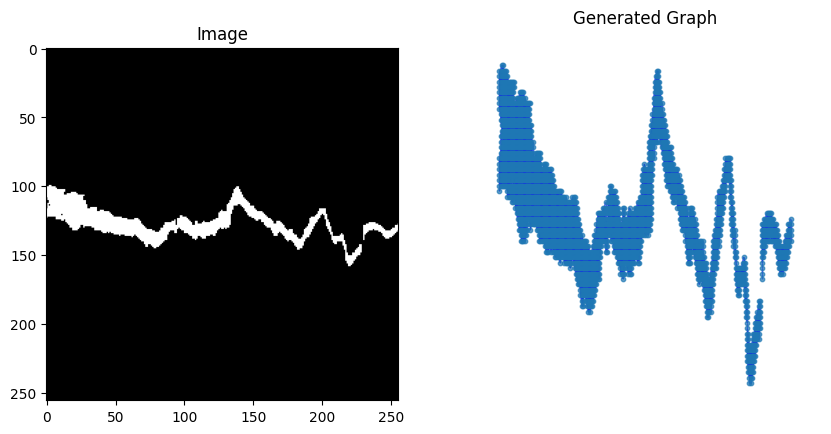

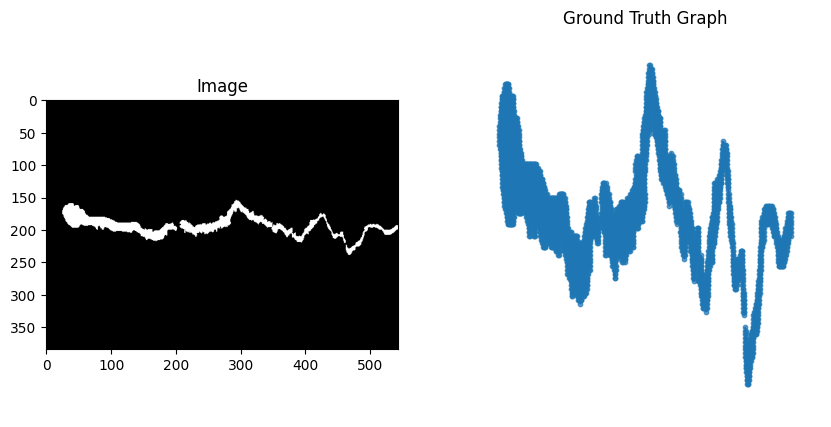

In [ ]:
import os
import numpy as np
import cv2
import networkx as nx
import matplotlib.pyplot as plt

# Function to convert skeleton to graph
def skeleton_to_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape

    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),          (0, 1),
                  (1, -1),  (1, 0), (1, 1)]

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                G.add_node((x, y))
                for dx, dy in directions:
                    nx_, ny_ = x + dx, y + dy
                    if 0 <= nx_ < rows and 0 <= ny_ < cols and skeleton[nx_, ny_] == 1:
                        if abs(dx) + abs(dy) == 2:
                            weight = np.sqrt(2)
                        else:
                            weight = 1
                        G.add_edge((x, y), (nx_, ny_), weight=weight)
    return G

# Function to find the longest crack path in the graph
def find_longest_path(G):
    start_node = list(G.nodes())[0]
    lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='weight')
    farthest_node = max(lengths, key=lengths.get)

    lengths = nx.single_source_dijkstra_path_length(G, farthest_node, weight='weight')
    other_farthest_node = max(lengths, key=lengths.get)

    path = nx.shortest_path(G, source=farthest_node, target=other_farthest_node, weight='weight')

    crack_length = 0
    for i in range(len(path)-1):
        crack_length += G[path[i]][path[i+1]]['weight']

    return crack_length, path

# Function to estimate the crack width (min, avg, max)
def estimate_crack_width(skeleton):
    min_widths = []
    max_widths = []
    total_widths = []
    rows, cols = skeleton.shape

    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                # Move horizontally to left and right (easy approx)
                left, right = 0, 0
                while y - left - 1 >= 0 and skeleton[x, y - left - 1] == 1:
                    left += 1
                while y + right + 1 < cols and skeleton[x, y + right + 1] == 1:
                    right += 1
                local_width = left + right + 1  # include center pixel
                total_widths.append(local_width)
                min_widths.append(left)
                max_widths.append(right)

    avg_width = np.mean(total_widths) if total_widths else 0
    min_width = np.mean(min_widths) if min_widths else 0
    max_width = np.mean(max_widths) if max_widths else 0

    return min_width, avg_width, max_width

# Function to calculate relative error
def calculate_relative_error(predicted, ground_truth):
    if ground_truth != 0 and abs(predicted - ground_truth) > 0.1:  # Tolerance for negligible errors
        return (predicted - ground_truth) / ground_truth * 100
    return 0  # If ground truth is 0 or the difference is negligible, error is considered 0

# Function to display the images and their graphs
def display_image_and_graph(image, graph, title="Graph"):
    # Display the image
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title("Image")

    # Plot the graph
    plt.subplot(122)
    pos = {node: (node[1], -node[0]) for node in graph.nodes()}  # invert y-axis for better visualization
    nx.draw(graph, pos, node_size=10, with_labels=False, font_size=8, edge_color='b', alpha=0.7)
    plt.title(title)
    plt.show()

# Function to process one image
def process_one_image(predicted_mask_path, ground_truth_mask_path):
    # Read the images (masks)
    predicted_mask = cv2.imread(predicted_mask_path, 0)  # Read as grayscale
    ground_truth_mask = cv2.imread(ground_truth_mask_path, 0)  # Read as grayscale

    # Threshold the images to ensure binary masks
    _, predicted_mask = cv2.threshold(predicted_mask, 127, 1, cv2.THRESH_BINARY)
    _, ground_truth_mask = cv2.threshold(ground_truth_mask, 127, 1, cv2.THRESH_BINARY)

    # Build the graph from the predicted mask
    G_pred = skeleton_to_graph(predicted_mask)
    print(f"Predicted Graph - Nodes: {len(G_pred.nodes())}, Edges: {len(G_pred.edges())}")

    # Find the longest crack path for predicted mask
    predicted_crack_length, _ = find_longest_path(G_pred)
    predicted_min_width, predicted_avg_width, predicted_max_width = estimate_crack_width(predicted_mask)

    # Build the graph from the ground truth mask
    G_gt = skeleton_to_graph(ground_truth_mask)
    print(f"Ground Truth Graph - Nodes: {len(G_gt.nodes())}, Edges: {len(G_gt.edges())}")

    # Find the longest crack path for ground truth mask
    ground_truth_crack_length, _ = find_longest_path(G_gt)
    ground_truth_min_width, ground_truth_avg_width, ground_truth_max_width = estimate_crack_width(ground_truth_mask)

    # Calculate errors
    error_length = calculate_relative_error(predicted_crack_length, ground_truth_crack_length)
    error_min_width = calculate_relative_error(predicted_min_width, ground_truth_min_width)
    error_max_width = calculate_relative_error(predicted_max_width, ground_truth_max_width)

    # Print results
    print(f"Predicted Crack Length: {predicted_crack_length:.2f} pixels")
    print(f"Predicted Min Crack Width: {predicted_min_width:.2f} pixels")
    print(f"Predicted Avg Crack Width: {predicted_avg_width:.2f} pixels")
    print(f"Predicted Max Crack Width: {predicted_max_width:.2f} pixels")
    print(f"Ground Truth Crack Length: {ground_truth_crack_length:.2f} pixels")
    print(f"Ground Truth Min Crack Width: {ground_truth_min_width:.2f} pixels")
    print(f"Ground Truth Avg Crack Width: {ground_truth_avg_width:.2f} pixels")
    print(f"Ground Truth Max Crack Width: {ground_truth_max_width:.2f} pixels")
    print(f"Relative Error for Length: {error_length:.2f}%")
    print(f"Relative Error for Min Width: {error_min_width:.2f}%")
    print(f"Relative Error for Max Width: {error_max_width:.2f}%")

    # Display the images and their graphs
    display_image_and_graph(predicted_mask, G_pred, title="Generated Graph")
    display_image_and_graph(ground_truth_mask, G_gt, title="Ground Truth Graph")

# Example usage
predicted_mask_path = '/content/drive/MyDrive/Crack Segmentaion/DeepCrack_gen/meta_ensemble/11162_meta_ensemble_prediction.png'  # Replace with the actual path
ground_truth_mask_path = '/content/drive/MyDrive/Crack Segmentaion/DeepCrack/11162.png'  # Replace with the actual path

# Process one image and display results
process_one_image(predicted_mask_path, ground_truth_mask_path)
